# Figures of Little Ice Age case study

## Readme
This notebook contains the analysis code behind the following paper:  
**Scheen, Jeemijn and Stocker, Thomas F., "Effect of changing ocean circulation on deep ocean temperature in the last millennium", submitted to Earth System Dynamics, 2020**   

In the following, this paper is abbreviated as "scheen20esd". 

- **Goal**: This notebook reads in the Bern3D model output data used in scheen20esd and reproduces all figures in the main text and Appendix A. The calculations behind Appendix B are provided as well.  


- **License**: This code is published open source under the [MIT license](https://github.com/jeemijn/LIA/blob/master/LICENSE) and the data under Creative Commons Attribution (CC BY 4.0). You are free to use the software, but need to reference it. Please consider to cite the doi of this code repository and/or the original paper scheen20esd. Final-version doi's for data and for code are cited in scheen20esd under Code and data availability.


- **Contact**: Please do not hesitate to contact the corresponding author in the case of questions or suspected bugs (Jeemijn Scheen, jeemijn.scheen@climate.unibe.ch). Although not required under the license, it is very much appreciated if you share any improvements/extensions of the code with me and if you consider to publish them open source.


**Explanation:**  
- Follow the [Readme on github](https://github.com/jeemijn/LIA) on where to download the data. You can choose between a small (default) and large version of the dataset. You only need the small versions to run this notebook, but you are free to explore additional variables in the large version. If you followed the Readme on github and chose the small data option, you don't need to adjust anything before running.
### WARNING: this notebook loads in 4 Gb into memory in the small version (default) or 22 Gb in the large version


- If you prefer different file paths than default, you should adjust the 2nd code cell below. If you took the large version, you need to change the 'data_mode' variable further below (and set the filepath to data_large).


- The code is written in python 3, since support of python 2 has stopped (more info [here](https://pythonclock.org) and [here](https://python3statement.org)). Most of the code would also run under python 2, but the alignment of e.g. annotations in the figures breaks down and possibly more breaks down in the future.  


- Documentation of user-defined functions can be found in the usual way, for example by 'f.temp_basin?'. The functions themselves can be found in functions.py. A few important functions are defined directly in this notebook.  


- You can use the bookmark links to navigate. For some figures you need to run additional cells first, as mentioned in the table of contents.

<a id='top'></a>

# Table of contents
*Subtitles below ("(A) Methods" etc.) correspond to the respective (sub)section titles in scheen20esd.*

*Figures can be run independently, but you always need to execute first:*
- [Set up notebook](#setup-notebook)    

*...and sections D) and F) need their respective set-up in addition (their first bullet point).*  

#### A) Modelling Framework
- [Figure 1](#fig1)

#### B) Circulation change
- [Figure 2](#fig2)
- [Figure 3](#fig3)

#### C) Propagation of temperature anomalies into the deep ocean
- [Figure 4](#fig4)

#### D) Decomposition of temperature anomalies
- [Set up decomposition](#setup-decomposition) 
- [Figure 5](#fig5)
- [Figure 6](#fig6)
- [Figure 7](#fig7)
- [Appendix Figure 2](#appfig2)

#### E) Explaining the leads and lags
- [Appendix Figure 1](#appfig1)
- [Figure 8-9](#fig8-9)
- [Appendix Figure 3](#appfig3)

#### F) Sensitivity of leads and lags
- [Set up sensitivity](#setup-sensitivity)
- [Appendix Figure 4](#appfig4)
- [Appendix Figure 5](#appfig5)
- [Figure 10](#fig10)

#### G) Comparison to Gebbie & Huybers (2019)
- [Figure 11](#fig11)

#### H) Appendix
- [Appendix B](#calc-appB)

#### I) Extra
- [How to strip netcdf to smaller file](#strip-nc)

<a id='setup-notebook'></a>

# Set up notebook
[go to top](#top)

In [1]:
## IMPORT PACKAGES:
# first time install all missing packages e.g. from notebook via !pip install xarray
import xarray as xr    
import numpy as np     
import scipy.optimize
import imp                                     # to import user-defined functions
from pathlib import Path                       # path objects to avoid inter-platform errors

# plot-related packages:
%matplotlib inline 
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns                          # plot style; we use either 'whitegrid' or 'ticks'
matplotlib.rcParams['savefig.bbox'] = 'tight'  # cuts off whitespace

## LOAD USER-DEFINED FUNCTIONS:
import functions as f                          # my own functions; call via f.function_name()

In [2]:
# DEFINE PATHS FOR DATA & FOR GENERATED FIGURES

# KEEP THE Path() FUNCTION AND USE FORWARD SLASHES / ON EVERY OPERATING SYSTEM
datadir = Path('./data_small/')  # load model output data from here
savedir = Path('./figures/')     # save all figures here (empty directory needs to exist at the start)

In [3]:
imp.reload(f)              # shows how to reload functions after a change without kernel restart

In [4]:
# expand paths because np.loadtxt can't handle home directory ~
datadir = datadir.expanduser()
savedir = savedir.expanduser()

# CHECKS
def check_dir(path):
    if not path.exists():
        raise Exception('File path ' + str(path) + ' does not exit. Correct or create first.')
check_dir(datadir)
check_dir(savedir)

# check python version
if 1/2 == 0:
    raise Exception("You are using python 2. Please use python 3 for a correct display of the figures.") 

In [5]:
## plot settings:
# larger labels
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

## define labels:
region_labels = ['north NAtl','mid NAtl','SAtl','NPac','SPac','SO','Arctic','Tropics']
# order of Dye1, Dye2 etc. in output:
dye_labels =    ['NADW','NAIW','SAIW','NPIW','SPIW','SO','Arctic','Tropics']

In [6]:
## SAVE RUNNAMES OF MODEL OUTPUT FILES, following the naming in scheen20esd (Table 1)

# SETTINGS:
# Set the wished data mode. Corresponding files must be saved in the datadir folder
data_mode = "_small"  # default: small data files
# data_mode = ""      # large data files (not needed but contain additional variables)

# original runnames are added as comments for internal use
OcTRA = 'OcTRA' + data_mode                        # LIADT_STD4
OcFIX = 'OcFIX' + data_mode                        # LIADF_STD4
OcTRA_weakmix = 'OcTRA_weakmix' + data_mode        # LIADT_WMD4
OcFIX_weakmix = 'OcFIX_weakmix' + data_mode        # LIADF_WMD4
OcTRA_strongmix = 'OcTRA_strongmix' + data_mode    # LIADT_SMD4
OcFIX_strongmix = 'OcFIX_strongmix' + data_mode    # LIADF_SMD4
OcTRA_weakwind = 'OcTRA_weakwind' + data_mode      # LIADT_WW_4
OcFIX_weakwind = 'OcFIX_weakwind' + data_mode      # LIADF_WW_4
OcTRA_strongwind = 'OcTRA_strongwind' + data_mode  # LIADT_SW_4
OcFIX_strongwind = 'OcFIX_strongwind' + data_mode  # LIADF_SW_4

# in the model output simulation year 0 is called 1765 CE (pre-industrial)
yr = '.0001765'
spinup_yr = 1765

## LOAD DATA
runs = [OcTRA, OcFIX]

# timeseries data are loaded into 'datas' and have annual resolution
# 3D variables are loaded into 'data_fulls' and typically have 5-yr output frequency
[datas, data_fulls] = f.load_data_multiple_runs(datadir, runs, spinup_yr)
for run in runs:
    for obj in [datas, data_fulls]: 
        # convert depth to km:
        obj[run]['z_t'] = obj[run]['z_t'] / 1000.0
        obj[run]['z_w'] = obj[run]['z_w'] / 1000.0
        # shift simulation time to time CE
        obj[run]['time'] += 1200 
        
# IN CASE OF AN ERROR: 
# MAKE SURE YOU DOWNLOADED THE DATA & THEIR LOCATION IS GIVEN IN THE PATH 'datadir' ABOVE
# MAKE SURE THE 'data_mode' ON TOP OF THIS CELL IS CORRECT

In [7]:
# define time steps of interest throughout this notebook
# according to 5-yr output frequency of data_full
t1 = 0     # at 1205 CE: start of simulation (1205 because first 3D output is after 5 years)
t2 = 109   # at 1750 CE: coldest point of LIA
t3 = 159   # at 2000 CE
print("Time steps of interest are: ", [round(data_fulls[OcTRA].time[t].item()) 
                                       for t in [t1, t2, t3]], " CE.")

Time steps of interest are:  [1205, 1750, 2000]  CE.


<a id='fig1'></a>

# A) Modelling Framework
# Figure 1
[go to top](#top)

global SST at t=0: 17.985422317794562


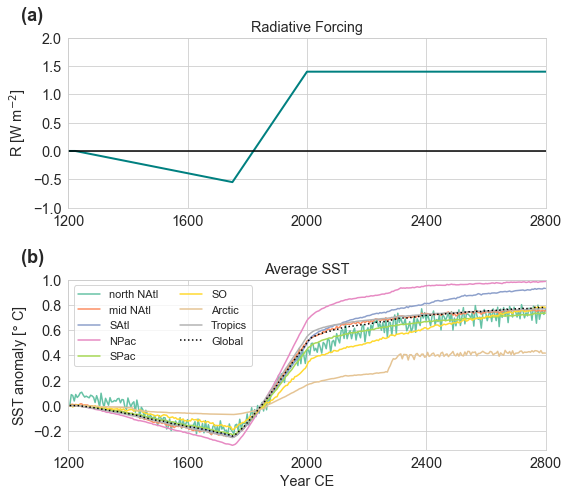

In [8]:
# Panels: a) radiative forcing, b) average SST

# SETTINGS:
only_dwf = False  # only plot DWF regions i.e. NADW and SO
anom = True       # plot SST time series as anomalies

dye_col = plt.cm.Set2.colors # color map same as in Appendix Figure 3
if only_dwf:
    this_dye_labels = ['NADW','SO'] 
    this_region_labels = [region_labels[0], region_labels[5]] # pick NADW and SO
    lstyle = ['solid', 'solid']
    dye_col = [dye_col[0], dye_col[5]] 
else:
    this_dye_labels = dye_labels        # all
    this_region_labels = region_labels  # all
#     lstyle = np.repeat('dotted', 8)   # non-DWF water masses with dotted line...
    lstyle = np.repeat('solid', 8)      # ...or instead all water masses with solid linestyle
    lstyle[0] = 'solid'                 # overwrite for NADW (DWF water mass)
    lstyle[5] = 'solid'                 # overwrite for SO (DWF water mass)

sns.set_style("whitegrid")
fig, ax = plt.subplots(2, figsize=(8,7))

forcing = np.loadtxt(datadir / 'forcing.dat')  # / because path object
forcing_x = forcing[:,0]
forcing_y = forcing[:,1]
forcing_x -= spinup_yr + 100  # start at -100 instead of 1765 (as first 100 years are constant)
# note that this forcing's time axis is not the same as of the final simulations
# because forcing was for coupled sim and then we saved SST/SSS only for the relevant part
fmin = round(forcing_y.min().item(), 2)
fmax = round(forcing_y.max().item(), 2)
ax[0].plot(forcing_x, forcing_y, linewidth=2, color='teal') 
ax[0].plot([0,forcing_x[-1]],[0,0],'k') 
ax[0].set_title('Radiative Forcing')
ax[0].set_ylabel("R [W " + r"m$^{-2}$" + "]") 
ax[0].set_ylim(-1.0,2.0) 
ax[0].set_yticks(np.arange(-1, 2.2, 0.5)) # ticks every 0.5 W/m2

vol = data_fulls[OcTRA].boxvol
sst = data_fulls[OcTRA].TEMP.isel(z_t=0)
if len(this_region_labels) is not len(this_dye_labels):
    raise Exception("region_labels should correspond to dye_labels!")
for n,dye in enumerate(this_dye_labels):
    sst_reg = f.area_mean_dye_regions(sst, vol, region=dye)
    if anom:
        ax[1].plot(sst.time, sst_reg-sst_reg[0], label=this_region_labels[n], linestyle=lstyle[n], 
                   color=dye_col[n])
    else:
        ax[1].plot(sst.time, sst_reg, label=this_region_labels[n], linestyle=lstyle[n], 
                   color=dye_col[n])

sst_glob = f.vol_mean(sst, vol.isel(z_t=0))
if anom:
    anom = sst_glob[0] # 17.985 C 
    print('global SST at t=0:', anom.item())
    ax[1].plot(sst.time, sst_glob - anom, 'k', label='Global', linestyle='dotted')
    ax[1].set_ylabel("SST anomaly [" + r"$\degree$" + " C]")
else:
    ax[1].plot(sst.time, sst_glob, 'k', label='Global')
    ax[1].set_ylabel("SST [" + r"$\degree$" + " C]")

## labels, titles, legend
ax[1].set_title("Average SST")
ax[1].set_xlabel("Year CE")
ax[1].legend(loc='upper left', prop={'size': 11}, ncol=2)
if anom:
    if only_dwf:
        ax[1].set_ylim([-0.25,0.8])
        ax[1].set_yticks(np.arange(-0.2, 0.9, 0.2))
    else:
        ax[1].set_ylim([-0.35,1.0]) # or: -0.4, 1
        ax[1].set_yticks(np.arange(-0.2, 1.1, 0.2)) # or: -0.4, 1.1, 0.2
else:
    ax[1].legend(loc='upper right', prop={'size': 11}, ncol=2)
xticks = np.arange(1200.0, 2900.0, 400.0)
for n, axis in enumerate(ax):
    ax[n].set_xticks(xticks) 
    ax[n].set_xlim(1200,2800)
    ax[n].text(-0.1, 1.1, '(' + chr(ord('a')+n) + ')', transform=ax[n].transAxes, 
               size=18, weight='bold')
plt.tight_layout(h_pad=2.0) # default is 1.08
plt.savefig(savedir / "Fig01_forcing_and_SST.pdf")  # / because path object

Note: the first 23 years of the simulation have constant forcing as a control.  
This also guarantees that the ocean circulation for fixed simulations is not influenced by the forcing, because fixed simulations repeat the circulation during the annual cycle of the first simulation year. 

<a id='fig2'></a>

# B) Circulation change
# Figure 2
[go to top](#top)

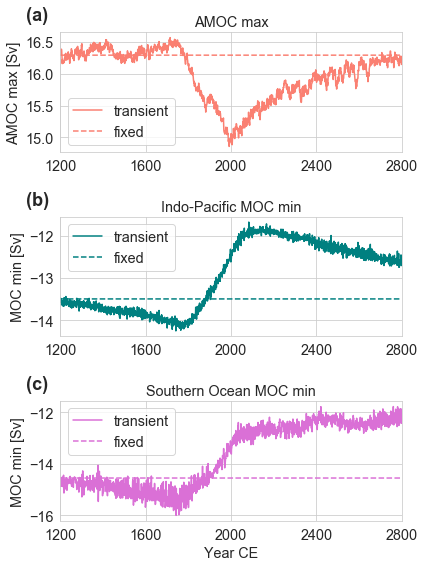

In [9]:
# timeseries of MOC
sns.set_style("whitegrid")
fig, ax = plt.subplots(3, figsize=(6,8))
        
time = datas[OcFIX].time

ax[0].plot(time, datas[OcTRA].OPSIA_max, 'salmon', label='transient', linestyle='solid') 
ax[0].plot(time, datas[OcFIX].OPSIA_max, 'salmon', label='fixed', linestyle='dashed') 
ax[0].set_ylabel('AMOC max [Sv]')
ax[0].set_title('AMOC max')

ax[1].plot(time, datas[OcTRA].OPSIP_min, 'teal', label='transient', linestyle='solid') 
ax[1].plot(time, datas[OcFIX].OPSIP_min, 'teal', label='fixed', linestyle='dashed') 
ax[1].set_ylabel('MOC min [Sv]')
ax[1].set_title('Indo-Pacific MOC min')

ax[2].plot(time, datas[OcTRA].OPSIS_min, 'orchid', label='transient', linestyle='solid') 
ax[2].plot(time, datas[OcFIX].OPSIS_min, 'orchid', label='fixed', linestyle='dashed') 
ax[2].set_ylabel('MOC min [Sv]')
ax[2].set_title('Southern Ocean MOC min')
ax[2].set_xlabel('Year CE')

for n,axis in enumerate(ax):
    axis.legend()
    axis.set_xlim(1200,2800)
    axis.set_xticks(range(1200,2900,400))
    ax[n].text(-0.1, 1.1, '(' + chr(ord('a')+n) + ')', transform=ax[n].transAxes, 
               size=18, weight='bold')
plt.tight_layout(h_pad=1.7)
plt.savefig(savedir / 'Fig02_amoc_somoc.pdf')

### determine relaxation time scale of MOCs

Fitting to psi(t) = psi_0 - A * exp(-t/tau) yields:
psi_0: 16.49672044411118 Sv
A:     99.99999999999999
tau:   470.1871353926805 yr
Covariance matrix of [psi_0, A, tau]:
 [[ 9.28172105e-04 -5.21192532e-01  6.32571204e-01]
 [-5.21192532e-01  3.17314527e+02 -3.79728837e+02]
 [ 6.32571204e-01 -3.79728837e+02  4.55671615e+02]]


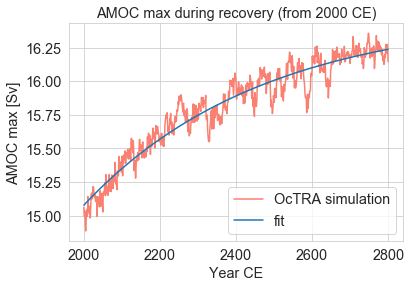

In [10]:
## AMOC: fit AMOC recovery using scipy optimization
# consider years 2000 to 2800 CE
times = slice(2000,2800) 

xlist = datas[OcTRA].time.sel(time=times)
ylist = datas[OcTRA].OPSIA_max.sel(time=times)

## define exponential function for fitting AMOC recovery
# this function converges to Psi_0 for t -> Infty, as desired
def psi_AMOC(t, psi_0, A, tau):
    """Exponential recovery of a stream function Psi back to its equilibrium value Psi_0,
    with relaxation/e-folding time scale tau and amplitude scaling factor A."""
    tau = float(tau)                   # s.t. no integer division under python 2
    return psi_0 - A * np.exp(-t/tau)  # -exp(-x) for shape increasing back to equilibrium

## optimize exponential fit
# min and max bounds of search window for [psi_0, A, tau] 
# based on trial and error
[min_params, max_params] = ([0, 0, 100],[40, 100, 10000])

[popt, pcov] = scipy.optimize.curve_fit(psi_AMOC, xdata=xlist, ydata=ylist, 
                                        bounds=(min_params, max_params)) 
# popt = found optimal parameters [psi_0, A, tau]
# pcov = covariance matrix; variance of resp. params on diagonal

## print result
print('Fitting to psi(t) = psi_0 - A * exp(-t/tau) yields:')
print('psi_0:', popt[0], 'Sv')
print('A:    ', popt[1])
print('tau:  ', popt[2], 'yr')
print('Covariance matrix of [psi_0, A, tau]:\n', pcov) 

## plot result
sns.set_style("whitegrid")
fig, ax = plt.subplots(1)
ax.plot(xlist, datas[OcTRA].OPSIA_max.sel(time=times), 'salmon', label='OcTRA simulation', 
        linestyle='solid')
ax.plot(xlist, [psi_AMOC(t, *popt) for t in xlist], label='fit')
ax.set_ylabel('AMOC max [Sv]')
ax.set_title('AMOC max during recovery (from 2000 CE)')
ax.set_xlabel('Year CE')
ax.legend()
plt.show()

Although this fit looks nice by eye, the indicated variance of tau is 456 yr (element 33 of the printed matrix), which is very high (compared to the found value of tau=470 yr).  
Nevertheless, we keep the result **tau = 470 yr**. Note that the value of psi_0 from the optimization is 16.5 Sv (with a variance of only ~0.001 Sv in matrix element 11), indicating that the **AMOC maximum will eventually recover to a 0.2 Sv stronger state than initially**

Fitting to psi(t) = psi_0 + A * exp(-t/tau) yields:
psi_0: -18.692360372169922 Sv
A:     10.306940842482922
tau:   5252.911415132125 yr
Covariance matrix of [psi_0, A, tau]:
 [[ 2.50449406e+01 -2.12536163e+01 -2.04332985e+04]
 [-2.12536163e+01  1.80398474e+01  1.73361725e+04]
 [-2.04332985e+04  1.73361725e+04  1.66750784e+07]]


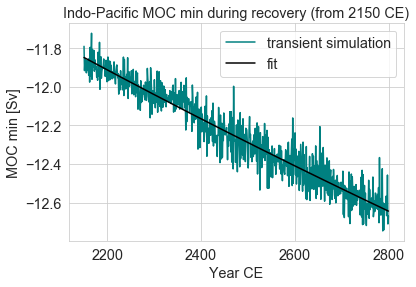

In [11]:
## repeat for IPMOC: fit Indo-Pacific MOC recovery using scipy optimization
# consider years 2150 to 2800 CE, because on [2000, 2150] no IPMOC recovery yet
times = slice(2150,2800) 

xlist = datas[OcTRA].time.sel(time=times)
ylist = datas[OcTRA].OPSIP_min.sel(time=times)

# define analagous function for fitting Indo-Pacific MOC recovery
# but now +exp(-x) instead of -exp(-x), because now DEcreasing back to equilibrium
def psi_IPMOC(t, psi_0, A, tau):
    """Exponential recovery of a stream function Psi back to its equilibrium value Psi_0,
    with relaxation/e-folding time scale tau and amplitude scaling factor A."""
    tau = float(tau)                   # s.t. no integer division under python 2
    return psi_0 + A * np.exp(-t/tau)  # +exp(-x) for shape decreasing back to equilibrium

# min and max bounds of search window for [psi_0, A, tau]
# by trial and error
[min_params, max_params] = ([-40, 0, 100],[0, 100, 10000])

[popt, pcov] = scipy.optimize.curve_fit(psi_IPMOC, xdata=xlist, ydata=ylist, 
                                        bounds=(min_params, max_params)) 

## print result
# popt = found optimal parameters [psi_0, A, tau]
print('Fitting to psi(t) = psi_0 + A * exp(-t/tau) yields:')
print('psi_0:', popt[0], 'Sv')
print('A:    ', popt[1])
print('tau:  ', popt[2], 'yr')
# pcov = covariance matrix; variance of resp. params on diagonal
print('Covariance matrix of [psi_0, A, tau]:\n', pcov) 

## plot result
sns.set_style("whitegrid")
fig, ax = plt.subplots(1)
ax.plot(xlist, datas[OcTRA].OPSIP_min.sel(time=times), 'teal', label='transient simulation', 
        linestyle='solid')
ax.plot(xlist, [psi_IPMOC(t, *popt) for t in xlist], label='fit', c='k')
ax.set_ylabel('MOC min [Sv]')
ax.set_title('Indo-Pacific MOC min during recovery (from 2150 CE)')
ax.set_xlabel('Year CE')
ax.legend()
plt.show()

Note the huge uncertainties on the diagonal of the covariance matrix. In addition, when playing around with tau values (in: min_params, max_params), producing a good fit by eye is very easy and not sensitive to tau. For instance, the plot for tau=1000 looks very similar to tau=5253 yr by eye. For AMOC however, it was very hard to get a good fit by playing around and much more sensitive to tau.   
Thus, the **relaxation time scale for IPMOC is not well constrained** based on this data until 2800, since the recovery looks so linear, and therefore IPMOC tau values are omitted from scheen20esd.

<a id='fig3'></a>

# Figure 3
[go to top](#top)

/usr/local/anaconda3/envs/py36/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


@1205 CE: global MOC min=-14.79 Sv, AMOC max=16.24 Sv
@1750 CE: global MOC min=-15.49 Sv, AMOC max=16.47 Sv
@2000 CE: global MOC min=-13.29 Sv, AMOC max=14.99 Sv


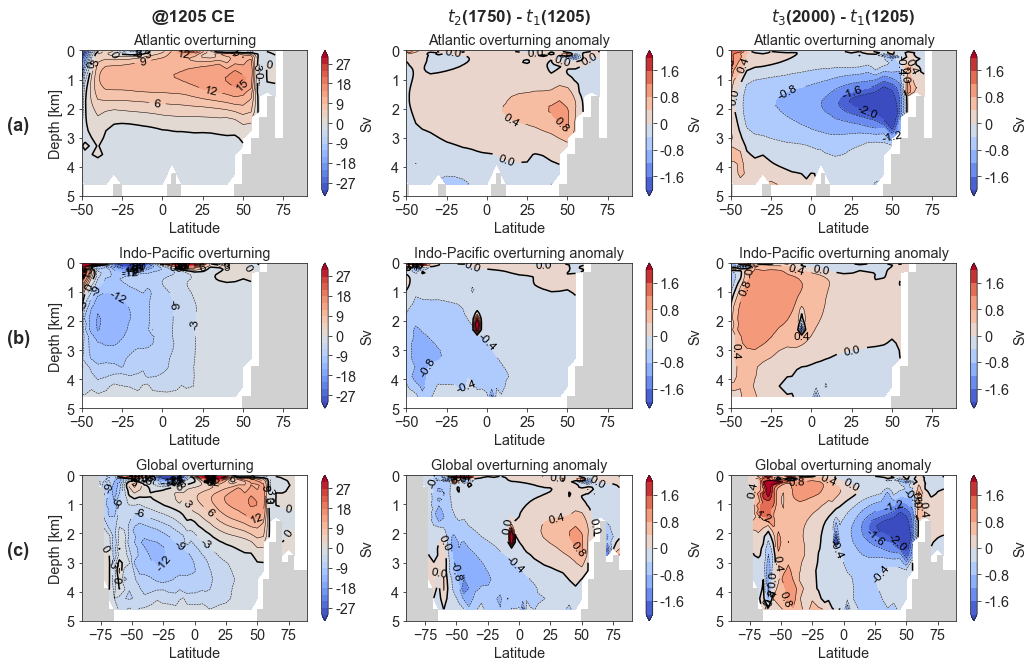

In [12]:
## Overturning circulation

# SETTINGS:
anom = True   # plot as anomalies (Fig 3) or not (additional figure; not used)
land = True   # add land profile on top in grey
levels = 20   # number of contour levels
hi = 30       # max value of colorbar
lo = -30      # min value of colorbar (must be symmetrical around 0)

sns.set_style("ticks")
times = data_fulls[OcTRA].time[[t1,t2,t3]]

# plotting
if anom:
    fig, ax = f.plot_overturning(datas[OcTRA], data_fulls[OcTRA], times, time_avg=True, 
                                 atl=True, pac=True, sozoom=False, levels=levels, lo=lo, hi=hi, 
                                 land=land, all_anoms=True)
else:
    fig, ax = f.plot_overturning(datas[OcTRA], data_fulls[OcTRA], times, time_avg=True, 
                                 atl=True, pac=True, sozoom=False, levels=levels, lo=lo, hi=hi, 
                                 land=land, all_anoms=False)

fig.subplots_adjust(wspace=0.15)

# bold time stamps on top
ax[0,0].text(x=0.31, y=1.2, s='@%1.0f' %(np.ceil(times[0])) + ' CE', 
             transform=ax[0,0].transAxes, fontsize=17, fontweight='bold')
if anom:
    ax[0,1].text(x=0.18, y=1.2, s=r'$t_2$'+'(%1.0f)' %(np.ceil(times[1]))+
                ' - '+r'$t_1$'+'(%1.0f)' %(np.ceil(times[0])), 
                 transform=ax[0,1].transAxes, fontsize=17, fontweight='bold')
    ax[0,2].text(x=0.18, y=1.2, s=r'$t_3$'+'(%1.0f)' %(np.ceil(times[2]))+
                ' - '+r'$t_1$'+'(%1.0f)' %(np.ceil(times[0])),
                 transform=ax[0,2].transAxes, fontsize=17, fontweight='bold')
else:
    ax[0,1].text(x=0.31, y=1.2, s='@%1.0f' %(np.ceil(times[1])) + ' CE', 
                 transform=ax[0,1].transAxes, fontsize=17, fontweight='bold')
    ax[0,2].text(x=0.31, y=1.2, s='@'+'%1.0f' %(np.ceil(times[2])) + ' CE',
                 transform=ax[0,2].transAxes, fontsize=17, fontweight='bold')

# panel numbering and labels
for row in [0,1,2]:
    ax[row,0].text(-0.33, 0.45, '(' + chr(ord('a')+row) + ')', transform=ax[row,0].transAxes, 
                   size=18, weight='bold')
    ax[row,1].set_ylabel("")    
    ax[row,2].set_ylabel("")    

if anom:
    plt.savefig(savedir / 'Fig03_overturning_anoms.pdf') 
else:
    plt.savefig(savedir / 'NOT_USED_overturning_vals.pdf')

<a id='fig4'></a>

# C) Propagation of temperature anomalies into the deep ocean
# Figure 4
[go to top](#top)

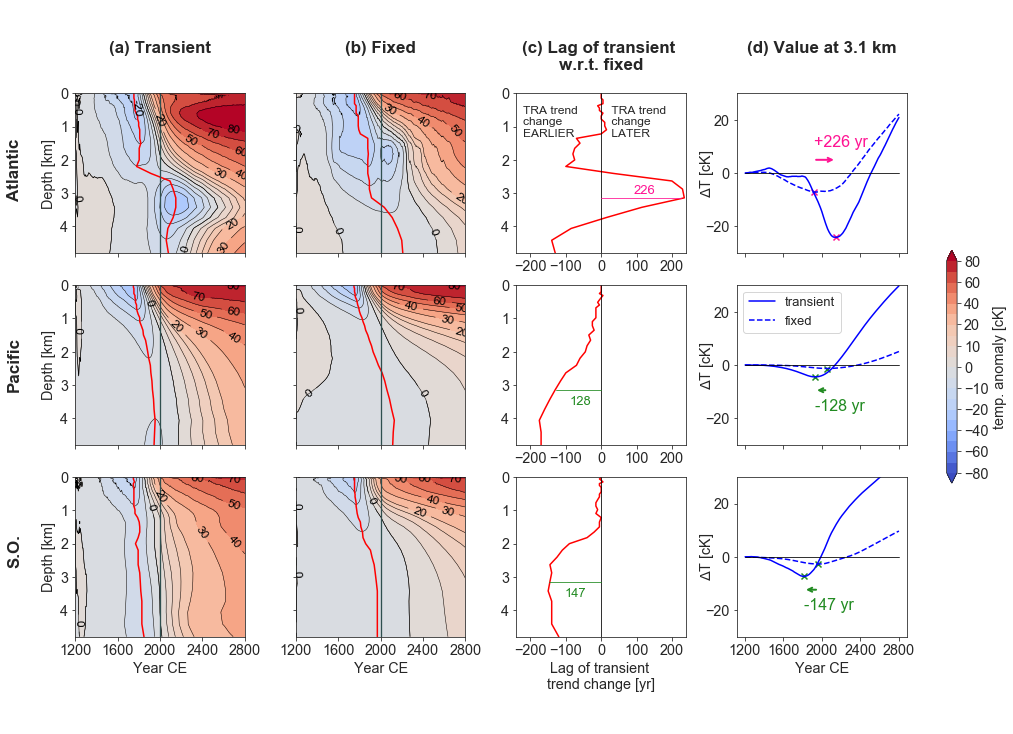

In [13]:
# Main figure of scheen20esd         --------- TAKES A WHILE (ESPECIALLY WITH RIDGES) -----
# Hovmoeller basin plots (Fig 4a,b) combined with leads and lags (Fig 4c,d)

# SETTINGS:
ridges = True   # plot red lines on top in col a,b of minimum temp anomaly
# note that 'ridge' is an outdated term; the red lines are rather troughs if you want 
# since they are temperature MINima
hi = 120        # max of colorbar
lo = -120       # min of colorbar (needs to be symmetric around 0)
# instead of 'levels' we now use 'levelarr', which allows non-uniform spacing:
a = np.arange(-80,-18,10) 
b = np.arange(-15,18,5)
c = np.arange(20,90,10) # set 1 higher because arange() excludes last one
levelarr = [a,b,c]  

# PREPARE TEMP ANOMALY DATA PER BASIN:
[pac_t, pac_f, atl_t, atl_f, so_t, so_f] = f.temp_basin(data_fulls[OcTRA], data_fulls[OcFIX])

sns.set_style("ticks")     
fig, ax = plt.subplots(3,4, figsize=(14,10))

## COL 1 & 2:  PLOT HOEVMILLER DIAGRAMS:
# plot_hovmoeller() already creates the subplot on fig,ax and also gives back [cpf, ridge]
[cpf, ridge_atl_t] = f.plot_hovmoeller(atl_t, fig, ax=ax[0,0], ridges=ridges, hi=hi, 
                                     lo=lo, cbar=False, levelarr=levelarr)
[junk, ridge_atl_f] = f.plot_hovmoeller(atl_f, fig,ax=ax[0,1], ridges=ridges, hi=hi, 
                                     lo=lo, cbar=False, levelarr=levelarr)
[junk, ridge_pac_t] = f.plot_hovmoeller(pac_t, fig, ax=ax[1,0], ridges=ridges, hi=hi, 
                                    lo=lo, cbar=False, levelarr=levelarr)
[junk, ridge_pac_f] = f.plot_hovmoeller(pac_f, fig, ax=ax[1,1], ridges=ridges, hi=hi, 
                                     lo=lo, cbar=False, levelarr=levelarr)
[junk, ridge_so_t] = f.plot_hovmoeller(so_t, fig, ax=ax[2,0], ridges=ridges, hi=hi, 
                                    lo=lo, cbar=False, levelarr=levelarr)
[junk, ridge_so_f] = f.plot_hovmoeller(so_f, fig, ax=ax[2,1], ridges=ridges, hi=hi, 
                                    lo=lo, cbar=False, levelarr=levelarr)

# set ticks
xticks = range(1200, 2900, 400)
yticks = range(0, 5, 1) # here I lose the 5 km tick s.t. no small white line at bottom
for i in [0,1,2]:
    ax[i,0].set_yticks(yticks) 
    ax[i,1].set_yticks(yticks) # sets ticks in correct places (tick labels removed below)
    ax[i,1].set_yticklabels("")
    ax[i,1].set_ylabel("")
    for j in [0,1,2]: 
        ax[i,j].set_ylim([4.8, 0]) # 4.8 km instead of 5 km s.t. no small white line at bottom
        if j != 2: # include col 2 in the (depth) y ticks but not in the (time) x ticks
            # add vertical lines at 2000 CE:
            ax[i,j].plot([2000,2000], [0,5], 'darkslategray', linewidth=1.3) 
            ax[i,j].set_xticks(xticks) # sets ticks in correct places (tick labels removed below)
for i in [0,1]: # only for two upper rows:
    for j in [0,1]:
        ax[i,j].set_xticklabels("")
        ax[i,j].set_xlabel("")
        ax[2,j].set_xlabel("Year CE") # overwrite x label
    
## PLOT LEADS AND LAGS
# COL 3: plot difference of the red lines <=> transient minus fixed minimum temp anom:
z_t = atl_t.z_t.values
ax[0,2].plot(ridge_atl_t - ridge_atl_f, z_t, 'r') 
ax[1,2].plot(ridge_pac_t - ridge_pac_f, z_t, 'r') 
ax[2,2].plot(ridge_so_t - ridge_so_f, z_t, 'r') 
for i in [0,1,2]:
    ax[i,2].plot([0,0], [0,5], linewidth=0.8, color='k') # plot zero line
    ax[i,2].set_xticks(range(-200,210,100))
    ax[i,2].set_xlim(-240,240)
    if i==0:
        ax[i,2].text(x=-220, y=1.3, s='TRA trend\nchange \nEARLIER', fontsize=12)
        ax[i,2].text(x=20, y=1.3, s=' TRA trend\n change \n LATER', fontsize=12)    
ax[2,2].set_xlabel("Lag of transient \ntrend change [yr]")

# COL 4:  PLOT VALUE AT 3 KM:
ax[0,3] = f.plot_leads_lags(atl_t, atl_f, ax[0,3], align='upper', color='blue')
ax[1,3] = f.plot_leads_lags(pac_t, pac_f, ax[1,3], color='blue')
ax[2,3] = f.plot_leads_lags(so_t, so_f, ax[2,3], color='blue')

# find the lead: only use the 5th object (this is the lead)
lead_atl = f.calc_leads_lags(atl_t, atl_f)[4]
lead_pac = f.calc_leads_lags(pac_t, pac_f)[4]
lead_so = f.calc_leads_lags(so_t, so_f)[4]

# set ticks and labels
ax[1,3].legend(loc="upper left", fontsize=13)
ax[2,3].set_xlabel("Year CE") 
for i in [0,1,2]:
    ax[i,3].plot([1200,2800], [0,0], linewidth=0.8, color='k') # plot zero line on bottom
    ax[i,3].set_ylabel(r"$\Delta$" + "T [cK]", labelpad=-10)   
    # labelpad small because can't use tight_layout
    ax[i,3].set_ylim([-30,30])
    ax[i,3].set_xticks(xticks) 
    ax[i,0].set_ylabel("Depth [km]")
for i in [0,1]:
    ax[i,3].set_xticklabels("") # delete x tick labels of 2 upper plots in column 3

# add leads also to col 3
ax[0,2].plot([-lead_atl,0],[3.14,3.14], linewidth=0.8, color='deeppink') # grid cell is at 3142 m
ax[1,2].plot([-lead_pac,0],[3.14,3.14], linewidth=0.8, color='forestgreen')
ax[2,2].plot([-lead_so,0], [3.14,3.14], linewidth=0.8, color='forestgreen')
ax[0,2].text(x=-lead_atl*0.4, y=3.0, s=str(abs(lead_atl)), color='deeppink', fontsize=13)
ax[1,2].text(x=-lead_pac*0.7, y=3.6, s=str(abs(lead_pac)), color='forestgreen', fontsize=13)
ax[2,2].text(x=-lead_so *0.7, y=3.6, s=str(abs(lead_so)),  color='forestgreen', fontsize=13)
              
# FIGURE TITLES
ax[0,0].set_title("(a) Transient\n\n", fontweight='bold', fontsize=17)
ax[0,1].set_title("(b) Fixed\n\n", fontweight='bold', fontsize=17)
ax[0,2].set_title("(c) Lag of transient \nw.r.t. fixed\n", fontweight='bold', fontsize=17)
ax[0,3].set_title("(d) Value at 3.1 km\n\n", fontweight='bold', fontsize=17)

# ANNOTATE BASINS
ax[0,0].text(x=-0.4, y=0.35, s="Atlantic", transform=ax[0,0].transAxes,
             fontsize=17, fontweight='bold', rotation=90)
ax[1,0].text(x=-0.4, y=0.35, s="Pacific", transform=ax[1,0].transAxes,
             fontsize=17, fontweight='bold', rotation=90)
ax[2,0].text(x=-0.4, y=0.45, s="S.O.", transform=ax[2,0].transAxes,
             fontsize=17, fontweight='bold', rotation=90)

# PLOT COLORBAR
# add colorbar on a new axis object (otherwise in weird location)
fig.subplots_adjust(right=0.95, wspace=0.3) 
# makes room for cbar and set width between subplots wider because tight_layout breaks down now
ax_cbar = fig.add_axes([0.93, 0, 0.07, 1.0]) # x0,y0 (lower left),w,h; width controls cbar size
ax_cbar.axis('off')
cbar = fig.colorbar(cpf, ax=ax_cbar, label='temp. anomaly [cK]', use_gridspec=True,
                    ticks=[-80,-60,-40,-20,-10,0,10,20,40,60,80])

plt.savefig(savedir / "Fig04_basins_leads_lags.pdf")

<a id='setup-decomposition'></a>

# D) Decomposition of temperature anomalies
# Set up decomposition
[go to top](#top)

Remark about the values of rho_0 and C_p that are used in Eq. (2) and (3) of scheen20esd:  
- The Bern3D model uses C_p = 3981.1 J/kg/K and rho_0 = 1000 kg/m3 for the computation of meridional heat flux output (HFLUX variable used in Fig. 5)
- We want to use instead a reference density that is more realistic for seawater and we want C_p = 3981 J/kg/K (less significant numbers). In Fig. 6 and Fig. 7 we just use these values we want directly (with the help of the functions defined below); for Fig. 5 we rescale the model output of HFLUX accordingly. 
- As a more realistic rho_0 we take the average ocean density in the model in steady state, namely 1027 kg/m3.

In [14]:
def temp_to_ocean_heat_density(main_obj, temp_obj, rho_approx=True):
    """Converts temperature to ocean heat density (OHD) via Eq. (3) in the paper scheen20esd.
    Input:
    - main_obj is dataset containing area, boxvol and (if rho_approx=False) rho_SI
    - temp_obj is data array containing temperature output (in Celsius).
      This is separate s.t. you can give in temperature difference of 2 runs (e.g. TRA and FIX).
    - rho_approx [default] changes the density of main_obj to the fixed reference 1027 kg/m3,
      because when comparing runs TRA and FIX it is unclear whose rho_i,j,k to take.
    Output:
    - ocean heat density(lat, lon, time) [xarray data array] in J/m2
    Author: Jeemijn Scheen, jeemijn.scheen@climate.unibe.ch"""

    C = 3981  # C_p in J/kg/K
    area = main_obj.area
    vol = main_obj.boxvol
    if rho_approx:
        rho = 1027             # kg/m3; equals avg density in ocean-only Bern3D, steady state
    else:
        rho = main_obj.rho_SI  # depending on grid cell i,j,k

    # make land nan (are now zeroes) & convert Celsius to Kelvin
    temp_Kelvin = temp_obj.where(temp_obj != 0.0, np.nan) + 273.15
    
    # Eq. (2) of scheen20esd gives heat content density Q_i,j,k
    Q = C * rho * temp_Kelvin  # J/m3
    
    # now integrate over z to get ocean heat density, following Eq. (3)
    OHD = (Q * vol/area).sum(dim='z_t')  # J/m2
    
    # make land nan again (are now zeroes); nan were converted back to zero by sum over z
    OHD = OHD.where(OHD != 0.0, np.nan)
    
    return OHD

def ohd_to_ohc(main_obj, OHD, basin='Global'):
    """Converts ocean heat density (OHD) to ocean heat content (OHC) via OHC = Integral OHD dx dy,
    taking either the global total OHC or per basin.
    Input:
    - main_obj is dataset containing masks and area
    - OHD is ocean heat density
    - if basin is 'Atlantic' or 'Pacific' then only Atlantic respectively Pacific, 
    excluding their Southern Ocean sector, is taken for the sum. 
        Default: Global.
    Output:
    - timeseries of OHC [xarray data array] in J for requested basin
    Author: Jeemijn Scheen, jeemijn.scheen@climate.unibe.ch"""
    
    from numpy import isin

    if not isin(basin, ['Atlantic', 'Pacific', 'Global']):
        raise Exception("Need to set basin to 'Atlantic', 'Pacific' or 'Global'.")
    
    area = main_obj.area
    
    # slice OHD to the required basin
    if basin == 'Atlantic':
        OHD = OHD.where(main_obj.mask.isel(z_t=0)==1) # atl excl S.O.
    elif basin == 'Pacific':
        OHD = OHD.where(main_obj.mask.isel(z_t=0)==2) # pac excl S.O.

    # integrate OHD (J/m2) over latitude and longitude since OHC = Integral OHD dx dy
    OHC = (OHD * area).sum(dim='lon_t').sum(dim='lat_t')  # J; time dimension remains
    
    # make land nan again (are now zeroes); nan were converted back to zero by sum over lat,lon
    OHC = OHC.where(OHC != 0.0, np.nan)
    
    return OHC    

# COMPUTE OCEAN HEAT DENSITY
ohd_TRA = temp_to_ocean_heat_density(data_fulls[OcTRA], data_fulls[OcTRA].TEMP, rho_approx=True)
ohd_FIX = temp_to_ocean_heat_density(data_fulls[OcFIX], data_fulls[OcFIX].TEMP, rho_approx=True)

Note that we always take rho_approx=True i.e. we use a fixed reference rho_0 and not the exact density rho_i,j,k depending on grid cell.
The reason is that for some calculations rho_i,j,k cannot be used (for the TRA minus FIX temperature it is unclear whose rho_i,j,k field one should take).
Therefore, we use rho_0 everywhere to be consistent.  
The difference is small anyway (in the 3rd digit and not visible by eye in the figures).

<a id='fig5'></a>

# Figure 5
[go to top](#top)

For explanation of the decomposition: see Eq. (1) in scheen20esd and the text around there.  
The separate terms are repeated here (without explanation):  
- v_0 Q_0 = steady state  
- (vQ) = all terms = transient  
- v_0 Q_0 + v_0 Q' = fixed since then v'=0  
- v' Q_0 + v' Q' = v' Q = transient-fixed = the effect of changing circulation  
- v_0 Q' = fixed - fixed[t=0] = the effect of changing SST 

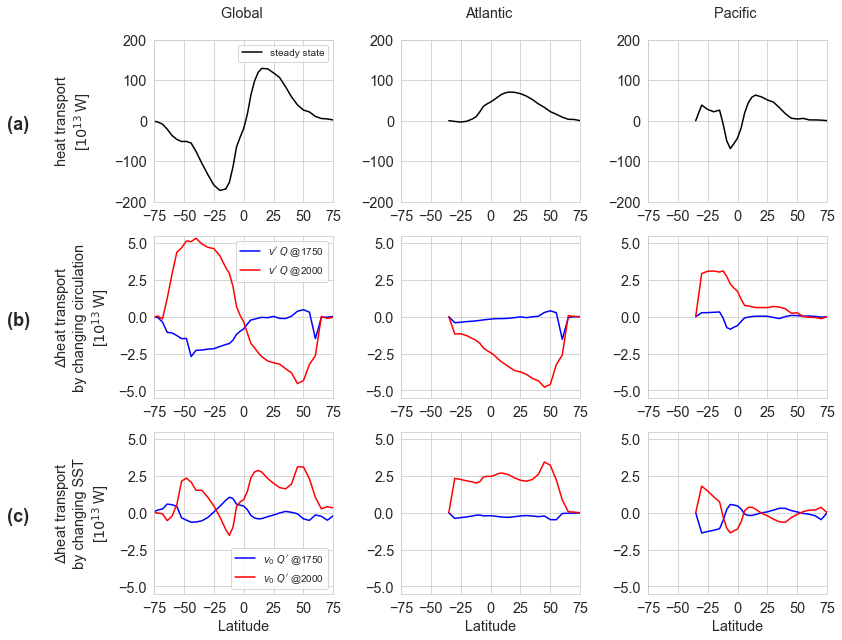

In [15]:
# Northward meridional heat flux

# We convert from the values that were used in the model for the HFLUX output 
# (namely: C_p=3981.1 J/kg/K, rho_0=1000 kg/m3) 
# to the values we want (C_p=3981 J/kg/K, rho_0=1027 kg/m3) by a uniform scaling 
# Why? see remark above under Set up decomposition
scaling = 3981.0 * 1027 / (3981.1 * 1000)

obj_t = data_fulls[OcTRA].HFLUX * scaling          # transient
obj_f = data_fulls[OcFIX].HFLUX * scaling          # fixed
obj_t_atl = data_fulls[OcTRA].HFLUX_ATL * scaling  # transient Atl, etc.
obj_f_atl = data_fulls[OcFIX].HFLUX_ATL * scaling
obj_t_pac = data_fulls[OcTRA].HFLUX_PAC * scaling
obj_f_pac = data_fulls[OcFIX].HFLUX_PAC * scaling

# Variables HFLUX_ATL and HFLUX_PAC are 0 south of 30S 
# because this falls outside the atl/pac basin definition. 
# Since plotting a 0 line here is misleading, we chose to 
# plot no line at all south of 30S for atl and pac.

# So we replace zeros by nan:
# -37 lies between grid cell boundaries -35 and -40
# in this way we still keep one 0 value at -35 s.t. graph starts from 0
# We do the same in the Arctic, stopping at 77N between grid cells 75 and 80
obj_t_atl = obj_t_atl.where(obj_t_atl.lat_u > -37.0).where(obj_t_atl.lat_u < 77.0)
obj_f_atl = obj_f_atl.where(obj_f_atl.lat_u > -37.0).where(obj_f_atl.lat_u < 77.0)
obj_t_pac = obj_t_pac.where(obj_t_pac.lat_u > -37.0).where(obj_t_pac.lat_u < 77.0)
obj_f_pac = obj_f_pac.where(obj_f_pac.lat_u > -37.0).where(obj_f_pac.lat_u < 77.0)
   
sns.set_style("whitegrid")
fig, ax = plt.subplots(3,3, figsize=(12,9))  

# x axis is latitude on u-grid i.e. at grid cell boundary because a flux
lat_u = data_fulls[OcFIX].lat_u

# In this figure all values (y axis) are divided by 10^13 s.t. units in 10^13 W

# column 1 (total ocean heat transport):
# global steady state (1205 CE fixed)
ax[0,0].plot(lat_u, obj_f.isel(time=t1)/1.0e13, color='k', linestyle='solid', 
             label='steady state')
ax[0,1].plot(lat_u, obj_f_atl.isel(time=t1)/1.0e13, color='k', linestyle='solid', 
             label='steady state')
ax[0,2].plot(lat_u, obj_f_pac.isel(time=t1)/1.0e13, color='k', linestyle='solid', 
             label='steady state')

cols = ['blue', 'red'] # colours correspond to t2 (end of LIA cooling; 1750), t3 (warming; 2000)
for n,t in enumerate([t2, t3]):
    # row 2 (anomaly by changing circulation):
    # v' Q   <=> redistribution heat transport <=> transient minus fixed <=> changing circulation
    time_str = str(int(round(data_fulls[OcFIX].time[t].item())))
    ax[1,0].plot(lat_u, (obj_t.isel(time=t) - obj_f.isel(time=t))/1.0e13, color=cols[n], 
                 linestyle='solid', label=r"$v^{\prime}\;Q$" + " @"+ time_str)
    ax[1,1].plot(lat_u, (obj_t_atl.isel(time=t) - obj_f_atl.isel(time=t))/1.0e13, color=cols[n], 
                 linestyle='solid', label=r"$v^{\prime}\;Q$" + " @"+ time_str)
    ax[1,2].plot(lat_u, (obj_t_pac.isel(time=t) - obj_f_pac.isel(time=t))/1.0e13, color=cols[n], 
                 linestyle='solid', label=r"$v^{\prime}\;Q$" + " @"+ time_str)

    # row 3 (anomaly by changing SST):
    # v_0 Q' <=> fixed anomalies <=> changing SST 
    ax[2,0].plot(lat_u, (obj_f.isel(time=t) - obj_f.isel(time=t1))/1.0e13, color=cols[n], 
                 linestyle='solid', label=r"$v_0\;Q^{\prime}$" + " @"+ time_str)
    ax[2,1].plot(lat_u, (obj_f_atl.isel(time=t) - obj_f_atl.isel(time=t1))/1.0e13, color=cols[n], 
                 linestyle='solid', label=r"$v_0\;Q^{\prime}$" + " @"+ time_str)
    ax[2,2].plot(lat_u, (obj_f_pac.isel(time=t) - obj_f_pac.isel(time=t1))/1.0e13, color=cols[n], 
                 linestyle='solid', label=r"$v_0\;Q^{\prime}$" + " @"+ time_str)

## titles, labels & ticks
ax[0,0].set_title("Global \n")
ax[0,1].set_title("Atlantic \n")
ax[0,2].set_title("Pacific \n")
ax[0,0].text(-0.4, 0.5, transform=ax[0,0].transAxes, rotation='vertical', size=14.5, 
             s="heat transport\n[" + r"$10^{13}$" + " W]\n", ha="center", va="center")
ax[1,0].text(-0.4, 0.5, transform=ax[1,0].transAxes, rotation='vertical', size=14.5, 
             s=r"$\Delta$"+"heat transport\nby changing circulation\n["+r"$10^{13}$"+" W]", 
             ha="center", va="center")
ax[2,0].text(-0.4, 0.5, transform=ax[2,0].transAxes, rotation='vertical', size=14.5, 
             s=r"$\Delta$"+"heat transport\nby changing SST\n["+r"$10^{13}$"+" W]", 
             ha="center", va="center")
for col in [0,1,2]:
    ax[0,col].set_ylim(-200, 200)  # in 10^13 W
    ax[1,col].set_ylim(-5.5, 5.5)  # in 10^13 W
    ax[2,col].set_ylim(-5.5, 5.5)  # in 10^13 W
    ax[2,col].set_xlabel("Latitude")
for row in [0,1,2]:
    ax[row,0].legend(fontsize=10, loc='upper right')
    ax[row,0].set_xticks(np.arange(-75,80,25))
    ax[row,0].text(-0.82, 0.45, '(' + chr(ord('a')+row) + ')', transform=ax[row,0].transAxes, 
                   size=18, weight='bold')
    for col in [0,1,2]:
        ax[row,col].set_xticks(range(-75,100,25))
        ax[row,col].set_xlim(-75,75)
ax[2,0].legend(fontsize=10, loc='lower right') # overwrite s.t. other position for panel c

plt.tight_layout(w_pad=2)
plt.savefig(savedir / "Fig05_heat_transport_per_basin.pdf")

<a id='fig6'></a>

# Figure 6
[go to top](#top)

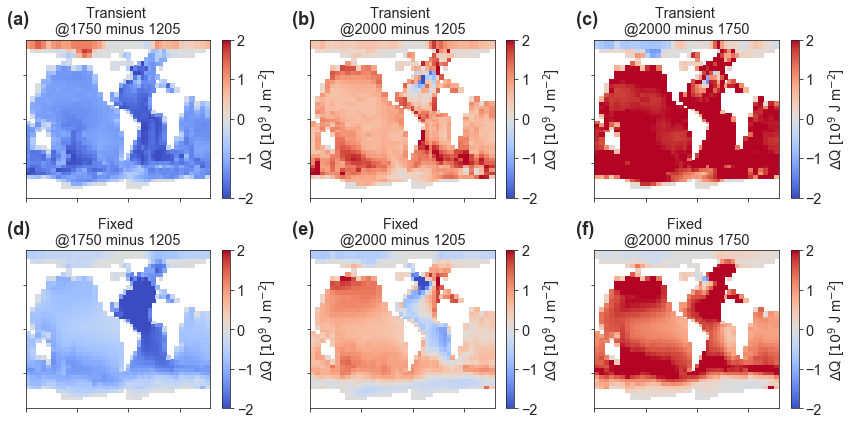

In [16]:
# ocean heat density (OHD) = heat content accumulated per water column

# SETTINGS:
cmap = 'viridis'        # colormap; good options: viridis, cool, plasma, autumn, Spectral_r
cmap_anom = 'coolwarm'  # colormap of anomaly panels

sns.set_style('ticks')
fig, ax = plt.subplots(2,3, figsize=(12,6))

xu = data_fulls[OcTRA].lon_u
yu = data_fulls[OcTRA].lat_u
t1_str = str(int(round(data_fulls[OcTRA].time[t1].item())))  # 1205 CE (first output after 5 yr)
t2_str = str(int(round(data_fulls[OcTRA].time[t2].item())))  # 1750 CE
t3_str = str(int(round(data_fulls[OcTRA].time[t3].item())))  # 2000 CE

# In this figure all values (y axis) are divided by 10^9 s.t. units in 10^9 J/m2
# ohd_TRA and ohd_FIX are computed above in 'Set up decomposition'
for row, obj in enumerate([ohd_TRA, ohd_FIX]): 
    # circulation type: transient (row 1), fixed (row 2)
    if row == 0:
        circ_str = 'Transient'
    elif row == 1:
        circ_str = 'Fixed'

    # column 1: 1750 (t2) anomaly w.r.t. 1200 (t1)
    Z = (obj.isel(time=t2) - obj.isel(time=t1)).values
    [ax[row,0],junk] = f.plot_surface(fig, ax[row,0], xu, yu, Z/1.0e9, cmap=cmap_anom, vmin=-2, 
                                      vmax=2, title=circ_str+" \n@"+t2_str+" minus "+t1_str,
                                      cbar_label=r'$\Delta$'+'Q ['+r'$10^9$'+' J m'+r'$^{-2}$'+']')
    
    # column 2: 2000 (t3) anomaly w.r.t. 1200 (t1)
    Z = (obj.isel(time=t3) - obj.isel(time=t1)).values
    [ax[row,1],junk] = f.plot_surface(fig, ax[row,1], xu, yu, Z/1.0e9, cmap=cmap_anom, vmin=-2, 
                                      vmax=2, title=circ_str+" \n@"+t3_str+" minus "+t1_str,
                                      cbar_label=r'$\Delta$'+'Q ['+r'$10^9$'+' J m'+r'$^{-2}$'+']')
    
    # column 3: 2000 (t3) anomaly w.r.t. 1750 (t2)
    Z = (obj.isel(time=t3) - obj.isel(time=t2)).values
    [ax[row,2],junk] = f.plot_surface(fig, ax[row,2], xu, yu, Z/1.0e9, cmap=cmap_anom, vmin=-2, 
                                      vmax=2, title=circ_str+" \n@"+t3_str+" minus "+t2_str,
                                      cbar_label=r'$\Delta$'+'Q ['+r'$10^9$'+' J m'+r'$^{-2}$'+']')
for n in range(0,3):
    ax[0,n].text(-0.1, 1.1, '(' + chr(ord('a')+n) + ')', transform=ax[0,n].transAxes, 
                 size=18, weight='bold')
    ax[1,n].text(-0.1, 1.1, '(' + chr(ord('d')+n) + ')', transform=ax[1,n].transAxes, 
                 size=18, weight='bold')

plt.tight_layout()
plt.savefig(savedir / 'Fig06_column_heat.pdf')

**Comparison of order of magnitude of anomalies with Winton et al. 2013, Fig. 2:**  
- Winton, M., Griffies, S. M., Samuels, B. L., Sarmiento, J. L., and Frölicher, T. L.: Connecting Changing Ocean Circulation with Changing Climate, Journal of Climate, 26, 2268–2278, https://doi.org/10.1175/JCLI-D-12-00296.1, 2013  

Their Figure 2 uses as unit W/m2* 90yr =  J/m2 * 90 * 3600* 24* 365.25 = 2.8e9 J/m2. We check that our results are on the same order of magnitude as what they found. They have values for delta_Q around 1 to 10 W/m2* 90yr, which equals 2.8e9 to 2.8e10 J/m2 converted to our units. So my delta_Q should be roughly 1e9 to 1e10 J/m2 or possibly half of this since our LIA perturbation is much smaller than their warming. **This corresponds nicely** (our average is -0.8e9 for transient in panel a resp. -0.7e9 for fixed in panel d). 

<a id='fig7'></a>

# Figure 7
[go to top](#top)

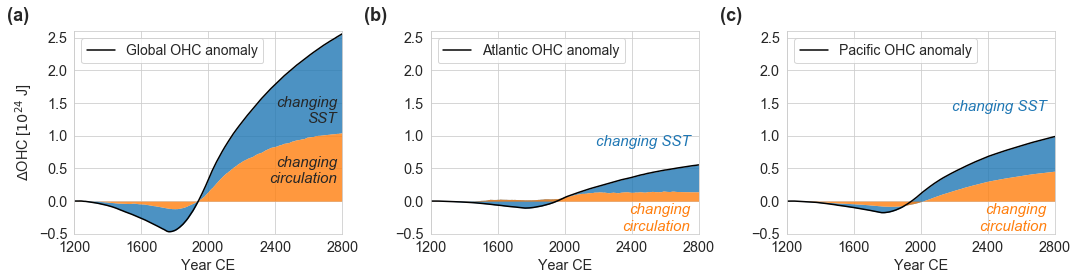

In [17]:
# decomposition of OHC
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,3, figsize=(15,4))

for col, basin in enumerate(['Global', 'Atlantic', 'Pacific']):
    ## computations
    # compute OHC for specific basin
    ohc_TRA = ohd_to_ohc(data_fulls[OcTRA], ohd_TRA, basin=basin)
    ohc_FIX = ohd_to_ohc(data_fulls[OcFIX], ohd_FIX, basin=basin)

    ## decompose
    steady_state = ohc_FIX.isel(time=0)
    changing_circ = ohc_TRA - ohc_FIX
    changing_SST = ohc_FIX - steady_state
    total = ohc_TRA
    
    ## plotting
    # In this figure all values (y axis) are divided by 10^24 s.t. units in 10^24 J
    ax[col].fill_between(changing_circ.time, (changing_circ+changing_SST)/1.0e24, 
                         changing_circ/1.0e24, linewidth=0, alpha=0.8, color='C0')
    ax[col].fill_between(changing_circ.time, changing_circ/1.0e24, 0, linewidth=0, 
                         alpha=0.8, color='C1') 

    ## plot black line on top and add in legend:
    ax[col].plot(total.time, (total-steady_state)/1.0e24, 'k', label=basin + " OHC anomaly")
    ax[col].legend(loc='upper left', fontsize=14)

    # labels and ticks
    ax[col].set_xlabel("Year CE")
    ax[col].set_xlim(1200,2800)
    xticks = range(1200, 3000, 400)
    ax[col].set_xticks(xticks)
    ax[col].set_ylim(-0.5, 2.6)
    yticks = np.arange(-0.5, 2.7, 0.5) # in 10^24 J
    ax[col].set_yticks(yticks)
    ax[col].text(-0.25, 1.05, '(' + chr(ord('a')+col) + ')', transform=ax[col].transAxes, 
                 size=18, weight='bold')

ax[0].set_ylabel(r"$\Delta$"+"OHC ["+r"$10^{24}$"+" J]")

# annotate both contributions (position depends on basin/axis)
text_props = {'size': 15, 'horizontalalignment': 'right', 'style': 'italic'}
ax[0].text(2770, 1.2, 'changing\nSST', fontdict=text_props)
ax[0].text(2770, 0.28, 'changing\ncirculation', fontdict=text_props)
ax[1].text(2750, 0.85, 'changing SST', fontdict=text_props, color='C0')
ax[1].text(2750, -0.45, 'changing\ncirculation', fontdict=text_props, color='C1')
ax[2].text(2750, 1.38, 'changing SST', fontdict=text_props, color='C0')
ax[2].text(2750, -0.45, 'changing\ncirculation', fontdict=text_props, color='C1')

plt.tight_layout()
plt.savefig(savedir / 'Fig07_decomposition_ohc.pdf')

<a id='appfig2'></a>

# Appendix Figure 2
[go to top](#top)

/Users/Jeemijn/Documents/PHD/Bern3D/notebooks_v20191015/functions.py:807: UserWarning: No contour levels were found within the data range.
  cp1 = ax.contour(X, Y, Z, a, colors='k', linestyles='-', linewidths=0.5) # contour lines


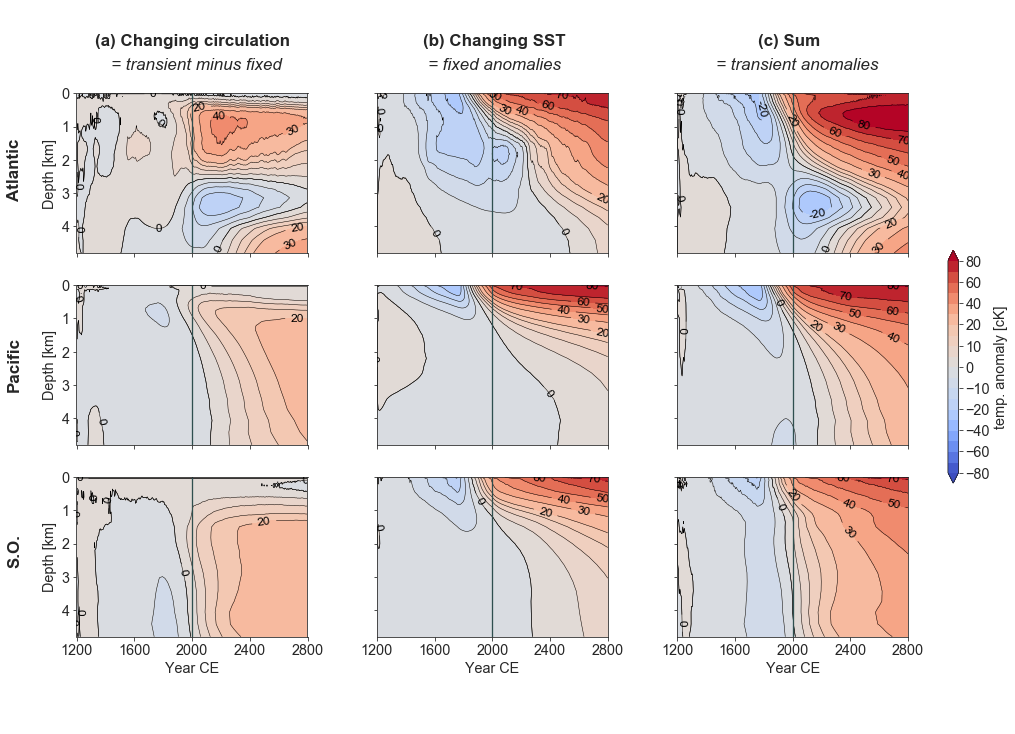

In [18]:
# Hovmoeller basin plots
# these panels are as in Fig 4a,b but now presented as a more extensive decomposition

## SETTINGS:
ridges = False   # plot red lines on top; makes no sense for column a so omitted
# note that 'ridge' is an outdated term; the red lines are rather troughs if you want 
# since they are temperature MINima
hi = 120        # max of colorbar
lo = -120       # min of colorbar (needs to be symmetric around 0)
# instead of 'levels' we use 'levelarr', which allows non-uniform spacing:
a = np.arange(-80,-18,10) 
b = np.arange(-15,18,5)
c = np.arange(20,90,10) # set 1 higher because arange() excludes last one
levelarr = [a,b,c]  

## COMPUTATIONS:
# prepare temperature data per basin in centi-Celsius (no cK because here no anomalies yet)
[pac_t, pac_f, atl_t, atl_f, so_t, so_f] = f.temp_basin(data_fulls[OcTRA], data_fulls[OcFIX], 
                                                        anoms=False)

# decompose for Atlantic
changing_circ_atl = atl_t - atl_f
changing_SST_atl = atl_f - atl_f.isel(time=0)
total_atl = atl_t - atl_t.isel(time=0)

# decompose for Pacific
changing_circ_pac = pac_t - pac_f              # in cK (= centi-Celsius here since anomaly now) 
changing_SST_pac = pac_f - pac_f.isel(time=0)  # in cK
total_pac = pac_t - pac_t.isel(time=0)         # in cK

# decompose for Southern Ocean
changing_circ_so = so_t - so_f
changing_SST_so = so_f - so_f.isel(time=0)
total_so = so_t - so_t.isel(time=0)

## PLOTTING:
sns.set_style('ticks')
fig, ax = plt.subplots(3,3, figsize=(14,10))

# plot_hovmoeller() already creates the subplot on fig,ax and also gives 
# back [cpf, ridge] or in this case [cpf]
# Only need to save colorbar object cpf once since it is the same every time
cpf = f.plot_hovmoeller(changing_circ_atl, fig, ax=ax[0,0], ridges=ridges,
               hi=hi, lo=lo, cbar=False, levelarr=levelarr)
f.plot_hovmoeller(changing_circ_pac, fig, ax=ax[1,0], ridges=ridges,
                     hi=hi, lo=lo, cbar=False, levelarr=levelarr)
f.plot_hovmoeller(changing_circ_so, fig, ax=ax[2,0], ridges=ridges,
               hi=hi, lo=lo, cbar=False, levelarr=levelarr)

f.plot_hovmoeller(changing_SST_atl, fig, ax=ax[0,1], ridges=ridges,
               hi=hi, lo=lo, cbar=False, levelarr=levelarr)
f.plot_hovmoeller(changing_SST_pac, fig, ax=ax[1,1], ridges=ridges,
               hi=hi, lo=lo, cbar=False, levelarr=levelarr)
f.plot_hovmoeller(changing_SST_so, fig, ax=ax[2,1], ridges=ridges,
               hi=hi, lo=lo, cbar=False, levelarr=levelarr)

f.plot_hovmoeller(total_atl, fig, ax=ax[0,2], ridges=ridges,
               hi=hi, lo=lo, cbar=False, levelarr=levelarr)
f.plot_hovmoeller(total_pac, fig, ax=ax[1,2], ridges=ridges,
               hi=hi, lo=lo, cbar=False, levelarr=levelarr)
f.plot_hovmoeller(total_so, fig, ax=ax[2,2], ridges=ridges,
               hi=hi, lo=lo, cbar=False, levelarr=levelarr)

# PLOT COLORBAR
# add colorbar on a new axis object (otherwise in weird location)
fig.subplots_adjust(right=0.95, wspace=0.3) 
# makes room for cbar and set width between subplots wider because can't use tight_layout
ax_cbar = fig.add_axes([0.93, 0, 0.07, 1.0]) # x0,y0 (lower left),w,h; width controls cbar size
ax_cbar.axis('off') 
cbar = fig.colorbar(cpf, ax=ax_cbar, label='temp. anomaly [cK]', use_gridspec=True, 
                    ticks=[-80,-60,-40,-20,-10,0,10,20,40,60,80])

# SET TICKS
xticks = range(1200, 2900, 400)
yticks = range(0, 5, 1) # here I lose the 5 km tick s.t. no small white line at bottom
for i in [0,1,2]:
    ax[i,0].set_yticks(yticks) 
    ax[i,1].set_yticks(yticks) # sets ticks in correct places (tick labels removed below)
    ax[i,1].set_yticklabels("")
    ax[i,2].set_yticklabels("")
    ax[i,1].set_ylabel("")
    ax[i,2].set_ylabel("")
    for j in [0,1,2]: 
        ax[i,j].set_ylim([4.8, 0]) # 4.8 km instead of 5 km s.t. no small white line at bottom
        # add vertical lines at 2000 CE:
        ax[i,j].plot([2000,2000],[0,5], 'darkslategray', linewidth=1.3) 
        ax[i,j].set_xticks(xticks) # sets ticks in correct places (tick labels removed below)
for i in [0,1]: # only for two upper rows:
    for j in [0,1,2]:
        ax[i,j].set_xticklabels("")
        ax[i,j].set_xlabel("")
        ax[2,j].set_xlabel("Year CE") # overwrite x label    

# FIGURE TITLES WITH 2 LINES
ax[0,0].text(x=0.08, y=1.3, s="(a) Changing circulation", transform=ax[0,0].transAxes, 
             fontsize=17, fontweight='bold')
ax[0,0].text(x=0.15, y=1.15, s="= transient minus fixed", transform=ax[0,0].transAxes, 
             fontsize=17, fontstyle='italic')

ax[0,1].text(x=0.2, y=1.3, s="(b) Changing SST", transform=ax[0,1].transAxes, 
             fontsize=17, fontweight='bold')
ax[0,1].text(x=0.22, y=1.15, s="= fixed anomalies", transform=ax[0,1].transAxes, 
             fontsize=17, fontstyle='italic')

ax[0,2].text(x=0.35, y=1.3, s="(c) Sum", transform=ax[0,2].transAxes, 
             fontsize=17, fontweight='bold')
ax[0,2].text(x=0.17, y=1.15, s="= transient anomalies", transform=ax[0,2].transAxes, 
             fontsize=17, fontstyle='italic')

# ANNOTATE BASINS
ax[0,0].text(x=-0.3, y=0.35, s="Atlantic", transform=ax[0,0].transAxes, 
             fontsize=17, fontweight='bold', rotation=90)
ax[1,0].text(x=-0.3, y=0.35, s="Pacific", transform=ax[1,0].transAxes, 
             fontsize=17, fontweight='bold', rotation=90)
ax[2,0].text(x=-0.3, y=0.45, s="S.O.", transform=ax[2,0].transAxes, 
             fontsize=17, fontweight='bold', rotation=90)

plt.savefig(savedir / 'AppFig02_basins_decomposition.pdf')

<a id='appfig1'></a>

# E) Explaining the leads and lags
# Appendix Figure 1
[go to top](#top)

In [19]:
# PREPARATION:                           

# load in dyemask that is used as input for the simulations
dyemask = np.loadtxt(datadir / 'world_41x40.dyemask')

# delete first & last row and first & last column (used for periodic boundary conditions)
dyemask = dyemask[1:-1, 1:-1]  # result is 40x41, as required

# replace land (777) by nan
dyes = np.where(dyemask == 777, np.nan, dyemask)
# left over are the numbers 1 to 8 for the 8 dye tracers, in the order of dye_labels 

dyes = np.flip(dyes, axis=0) # bring north on top in ndarray

# np.unique(dyes)                    # check is correct
nr_dye = np.nanmax(np.unique(dyes))  # this is 8

In [20]:
# ## As a test, AppFig. 1 can be reproduced without using the input dyemask (needs data_mode=""), 
# ## but instead from the model output of surface dye. The result is the same so no mistake.

# # PREPARATION:
# ## create one object containing all dye tracers together

# # APPROACH: we determine the initial dye input from output dye concentration at the surface
# # Test histogram shows empty gap between 30-70% for surface dye concentrations
# # so we conclude that no dye input cell if < 30% dye at surface

# nr_dye = 8  # because used 8 dye tracers in the simulations
# t_step = 0  # first time step because this is still at equilibrium dye concentrations

# # combine all dye tracers at surface in one array
# dye_arr = [data_fulls[OcFIX]['Dye' + '%s' %str(n+1)].isel(time=t_step, z_t=0) 
#            for n in range(0,nr_dye)] 
# # convert to xarray by using area variable as example with correct lat/lon coords:
# dyes = data_fulls[OcFIX].area.copy(deep=True) 

# # fill 'dyes' with value of surface dye (close to 100%) if it is a dye input cell; else nan
# for lat in dyes.lat_t:
#     for lon in dyes.lon_t:
#         these_dyes = [dye_arr[n].sel(lat_t=lat, lon_t=lon).item() for n in range(0,nr_dye)]
#         # set dyes to value of dye tracer with the maximum dye concentration:
#         if np.asarray(these_dyes).max() > 30:
#             dyes.loc[lat, lon] = np.argmax(these_dyes) + 1
#         else: # no dye input cell if < 30% dye
#             dyes.loc[lat, lon] = np.nan # or 0

# # np.unique(dyes)  # check is correct

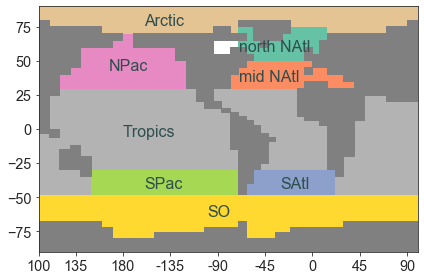

In [21]:
# Plot dye regions definition based on output data s.t. no mistakes can occur
# using 'dyes' object computed above

# SETTINGS:
cbar = False         # cbar can be added
text = True          # plot text on top of regions
cmap = plt.cm.Set2   # colormap; must have correct number of discrete colors

sns.set_style("ticks")
fig, ax = plt.subplots(1)

xu = data_fulls[OcFIX].lon_u
yu = data_fulls[OcFIX].lat_u
cpf = ax.pcolor(xu, yu, f.extend(dyes), cmap=cmap, vmin=1, vmax=nr_dye + 1)

# land:    
land_mask = data_fulls[OcFIX].masks.where(data_fulls[OcFIX].masks == 0)
land_mask_surf = land_mask.sel(z_t=land_mask.z_t[0])
# add grey land
ax.pcolor(xu, yu, f.extend(land_mask_surf), cmap=plt.cm.gray, vmin=-0.5, vmax=0.5, alpha=1.0)
ax.set_xlabel("")
ax.set_ylabel("")
if cbar:
    cbar = fig.colorbar(cpf, ax=ax, extend='neither', ticks=range(1, nr_dye + 1, 1))
    cbar.set_ticks(np.asarray(np.arange(1.5, nr_dye + 1.5, 1)))
    cbar.ax.set_yticklabels(region_labels)  # vertically oriented colorbar
    cbar.ax.yaxis.set_tick_params(pad=7)
    cbar.set_label('')
if text:
    regions_lon = [290,290,330,167,200,260,200,180]  
    regions_lat = [57,35,-43,43,-43,-64,76,-5]
    for i,reg in enumerate(region_labels):
        ax.text(regions_lon[i], regions_lat[i], reg, 
                fontdict = {'size': 16, 'color': 'darkslategrey'}) # darkslategrey, black or navy
xticks = np.asarray(np.concatenate(([100.0],range(135,460,45))))   # w.r.t. Bern3D lon [100,460]
# convert from Bern3D lon axis to real lon:
xtick_labels = [str(int(round(x))) 
                for x in np.concatenate((xticks[xticks<=180], xticks[xticks>180] - 360.0))]  
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
plt.tight_layout()
plt.savefig(savedir / 'AppFig01_dye_tracer_locations.pdf') 
plt.show()

<a id='fig8-9'></a>

# Figure 8-9
[go to top](#top)

Both of these figures plot the same variables, dye and ideal age, for respectively the Atlantic and Pacific.  
In the settings you can also choose to plot the Indian Ocean or Southern Ocean instead, or to plot all values as non-anomaly values (all not used in scheen20esd).  
Listing level and axis boundaries for all these separately became very chaotic. Therefore we use **a class to organize the plot configurations**:

In [22]:
# DEFINE CLASS
class ConfigContour:
    """Configurations are used to bundle parameters for a contour plot (e.g. dye or age plots).
    
    Properties:
    - lo, hi, levels set the lower and higher bound of the colorbar and nr of contour levels 
    - cmap sets the colormap
    - add_perc adds a '%' in the colorbar legend for dye vars (unit: % of initial concentration)
    - extend defines whether colorbar ends in arrows ('both') or is rectangular ('neither')
    - anom_ticks sets specific ticks for anomaly plots (if applicable)
    
    Author: Jeemijn Scheen, jeemijn.scheen@climate.unibe.ch"""
    
    def __init__(self, lo, hi, levels, cmap, add_perc=False, extend='both', anom_ticks=-1):
        self.lo = lo
        self.hi = hi
        self.levels = levels
        self.cmap = cmap
        self.add_perc = add_perc
        self.extend = extend
        self.anom_ticks = anom_ticks
        
# SET CONFIGURATIONS
# Organize settings in a 4x2x2 dict 'configs' filled with instances of the ConfigContour class.
configs = {
    ('Atlantic','dye',True):  ConfigContour(lo=-2, hi=2, levels=8, cmap='PuOr_r', 
                                            add_perc=True, extend='both', 
                                            anom_ticks=range(-2,3,1)), 
    ('Atlantic','dye',False): ConfigContour(lo=0, hi=100, levels=10, cmap='Oranges', 
                                            add_perc=True, extend='neither'),
    ('Atlantic','age',True):  ConfigContour(lo=-100, hi=100, levels=10, cmap='PuOr_r', 
                                            add_perc=False, extend='both', 
                                            anom_ticks=range(-100,110,50)), 
    ('Atlantic','age',False): ConfigContour(lo=0, hi=1000, levels=10, cmap='Blues', 
                                            add_perc=False, extend='neither'),
    ('Pacific','dye',True):   ConfigContour(lo=-2, hi=2, levels=40, cmap='PuOr_r', 
                                            add_perc=True, extend='both', 
                                            anom_ticks=range(-2,3,1)), 
    ('Pacific','dye',False):  ConfigContour(lo=0, hi=100, levels=20, cmap='Oranges', 
                                            add_perc=True, extend='neither'),
    ('Pacific','age',True):   ConfigContour(lo=-100, hi=100, levels=20, cmap='PuOr_r', 
                                            add_perc=False, extend='both', 
                                            anom_ticks=range(-100,110,50)), 
    ('Pacific','age',False):  ConfigContour(lo=0, hi=1500, levels=15, cmap='Blues', 
                                            add_perc=False, extend='neither'),
    ('Indian','dye', True):   ConfigContour(lo=-2, hi=2, levels=40, cmap='PuOr_r', 
                                            add_perc=True, extend='both', 
                                            anom_ticks=range(-2,3,1)), 
    ('Indian','dye',False):   ConfigContour(lo=0, hi=100, levels=20, cmap='Oranges', 
                                            add_perc=True, extend='neither'),
    ('Indian','age',True):    ConfigContour(lo=-100, hi=100, levels=20, cmap='PuOr_r', 
                                            add_perc=False, extend='both', 
                                            anom_ticks=range(-100,110,50)), 
    ('Indian','age',False):   ConfigContour(lo=0, hi=1500, levels=15, cmap='Blues', 
                                            add_perc=False, extend='neither'),
    ('SO','dye',True):        ConfigContour(lo=-2, hi=2, levels=8, cmap='PuOr_r', 
                                            add_perc=True, extend='both', 
                                            anom_ticks=range(-2,3,1)), 
    ('SO','dye',False):       ConfigContour(lo=0, hi=100, levels=10, cmap='Oranges', 
                                            add_perc=True, extend='neither'),
    ('SO','age',True):        ConfigContour(lo=-100, hi=100, levels=10, cmap='PuOr_r', 
                                            add_perc=False, extend='both', 
                                            anom_ticks=range(-100,110,50)), 
    ('SO','age',False):       ConfigContour(lo=0, hi=1000, levels=10, cmap='Blues', 
                                            add_perc=False, extend='neither')
}

**Why are the configurations defined as above?**    
Configurations depend on basin (atl or pac) & variable type (dye or age) & whether anomaly plot or non-anomaly plot.  
Explanation of logic: 
- lo, hi, levels and cmap depend on the basin and var_type; found by 
  trial and error for nicest plots (e.g. Pac signal is weaker so needs more contour levels to visualize)
- for anom, we set anom_ticks and extend='both' and cmap='PuOr_r'
- for dye we set add_perc=True; for age add_perc=False
- Indian is just a copy of Pacific settings
- SO is just a copy of Atlantic settings

/Users/Jeemijn/Documents/PHD/Bern3D/notebooks_v20191015/functions.py:944: UserWarning: No contour levels were found within the data range.
  cp0 = ax.contour(X,Y,Z, level_arr[abs(level_arr)<1e-4], colors='k', linestyles='-', linewidths=1.5)
/Users/Jeemijn/Documents/PHD/Bern3D/notebooks_v20191015/functions.py:944: UserWarning: No contour levels were found within the data range.
  cp0 = ax.contour(X,Y,Z, level_arr[abs(level_arr)<1e-4], colors='k', linestyles='-', linewidths=1.5)
/Users/Jeemijn/Documents/PHD/Bern3D/notebooks_v20191015/functions.py:944: UserWarning: No contour levels were found within the data range.
  cp0 = ax.contour(X,Y,Z, level_arr[abs(level_arr)<1e-4], colors='k', linestyles='-', linewidths=1.5)


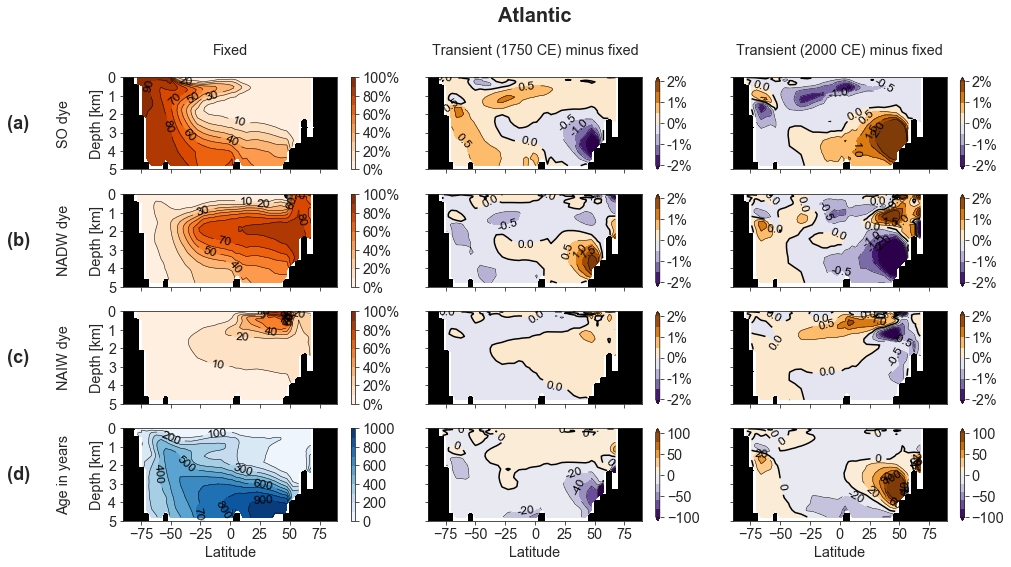

In [23]:
# DYE AND AGE                        --------------- TAKES A WHILE ---------------------

# SETTINGS: 
anoms = True         # anomalies of TRA minus FIX (as in Fig 8-9) or no anomalies
# choose a basin by commenting in one basin:
basin = 'Atlantic'
# basin = 'Pacific'
# basin = 'Indian'   # not used in scheen20esd
# basin = 'SO'       # not used in scheen20esd
times = [t2, t3]                # the 2 timesteps of interest: at year 1750 resp. 2000

# EXPLANATION:
# The rows contain multiple dye tracers and the last row is ideal age. The 3 columns are: 
# 1) fixed circulation at t1  2) transient circulation at t1  3) transient circulation at t2
# if anoms, then col 2 and 3 are plotted as anomalies w.r.t. fixed circulation

# DEFINE RELEVANT DYE TRACERS:
if basin == 'Atlantic' or basin == 'SO':
    dyes = [6,1,2]      # atl: SO, NADW, NAIW
elif basin == 'Pacific':
    dyes = [6,1,8]      # pac: SO, NADW, Tropics
elif basin == 'Indian':
    dyes = [6,1,8]
else:
    raise Exception("Set basin to Atlantic, Pacific, Indian, or SO.")
# variables to be plotted on rows: multiple dye tracers and lastly ideal age (ida)
row_vars = ['Dye' + str(this_dye) for this_dye in dyes] + ['ida']
if len(times) != 2:
    raise Exception("Times must have length 2")

sns.set_style("ticks")
fig, ax = plt.subplots(len(row_vars),3, figsize=(14,8))

# PLOTTING
# abbreviate
obj_t = data_fulls[OcTRA]        # transient circulation
obj_f = data_fulls[OcFIX]        # fixed circulation
masks = data_fulls[OcTRA].masks  # basin masks incl SO sectors
mask = data_fulls[OcTRA].mask    # basin masks excl SO sectors

create_land = True               # keeps track of whether land is already created
for row, var in enumerate(row_vars):
    # var can be of type dye [% concentration] or ideal age [year]:
    if var[0:3] == 'Dye':
        var_type = 'dye' 
    elif var[0:3] == 'ida':
        var_type = 'age'
    else:
        raise Exception("Variable type '" + var[0:3] + "' unknown (not dye or ideal age).")
        
    ## prepare dye/age concentration objects:
    if basin == 'Atlantic':
        # slice the var to basin and take zonal average (keeping depth, lat, time coords)
        conc_t = f.area_mean(obj_t, obj_t[var].where(masks==1), keep_lat=True, basin='atlso')
        conc_f = f.area_mean(obj_f, obj_f[var].where(masks==1), keep_lat=True, basin='atlso')
    elif basin == 'Pacific':
        conc_t = f.area_mean(obj_t, obj_t[var].where(masks==2), keep_lat=True, basin='pacso')
        conc_f = f.area_mean(obj_f, obj_f[var].where(masks==2), keep_lat=True, basin='pacso')
    elif basin == 'Indian':
        conc_t = f.area_mean(obj_t, obj_t[var].where(masks==3), keep_lat=True, basin='indso')
        conc_f = f.area_mean(obj_f, obj_f[var].where(masks==3), keep_lat=True, basin='indso')
    elif basin == 'SO':
        conc_t = f.area_mean(obj_t, obj_t[var].where(mask==4), keep_lat=True, basin='so')
        conc_f = f.area_mean(obj_f, obj_f[var].where(mask==4), keep_lat=True, basin='so')
        
    ## create and plot land
    if create_land: 
        X, Y = np.meshgrid(obj_t.lat_u.values, obj_t.z_w.values)     # same for all subplots
        [land_mask, cmap_land] = f.create_land_mask(conc_t, obj_t)   # same for conc_t and conc_f
        for i in np.arange(0,len(row_vars)): 
            for j in [0,1,2]:
                # add black land (color depends on vmin, vmax)
                ax[i,j].pcolormesh(X, Y, f.extend(land_mask), cmap=cmap_land, vmin=-0.5, vmax=0.5)
        create_land = False # only need to create land once

    ## COLUMN 1: fixed circulation 
    title = "Fixed\n"
    plot_obj = conc_f.isel(time=times[0])
    # NB timestep does not matter because fixed circulation is equal for all timesteps
    c = configs[basin, var_type, False]  # anom=False because column 1 is never an anomaly
    f.plot_contour(plot_obj, fig, ax=ax[row,0], var='CONC', levels=c.levels, hi=c.hi, lo=c.lo,
                   title=title, cmap=c.cmap, add_perc=c.add_perc, extend=c.extend)

    ## COLUMN 2 and 3: transient circulation at 2nd and 3th timestep of interest
    if anoms: 
        c = configs[basin, var_type, True] # anomaly plot = True
    for n,t_step in enumerate(times): 
        if anoms:
            title = "Transient ("+str(int(round(obj_t.time[t_step].item())))+" CE) minus fixed\n"
            plot_obj = conc_t.isel(time=t_step) - conc_f.isel(time=t_step)
        else:
            title = "Transient ("+str(int(round(obj_t.time[t_step].item())))+" CE)\n"
            plot_obj = conc_t.isel(time=t_step)
        # n=0 for col 2 and n=1 for col 3:
        cbar = f.plot_contour(plot_obj, fig, ax=ax[row,n+1], var='CONC', levels=c.levels, 
                              hi=c.hi, lo=c.lo, title=title, cmap=c.cmap, add_perc=c.add_perc, 
                              extend=c.extend)
        # adjust colour bar
        if anoms: 
            cbar.set_ticks(c.anom_ticks)
            if c.add_perc:
                cbar.ax.set_yticklabels([str(n) + '%' for n in c.anom_ticks]) 

# TICKS AND LABELS
for row in np.arange(len(row_vars)):
    ax[row,0].text(-0.54, 0.5, '(' + chr(ord('a')+row) + ')', transform=ax[row,0].transAxes, 
                   size=18, weight='bold', va='center')
    for col in [0,1,2]:
        ax[row,col].set_xticks(range(-75,80,25))
        if row != (len(row_vars)-1):
            ax[row,col].set_xlabel('')       # overwrite
            ax[row,col].set_xticklabels("")  # delete tick labels again if not in last row
        if row != 0:
            ax[row,col].set_title("")        # delete titles on all rows except top row
        if col == 0:
            if row == len(row_vars)-1:
                ax[row,col].set_ylabel("Age in years\n\nDepth [km]")
            else:
                ax[row,col].set_ylabel('%s dye\n \nDepth [km]' %dye_labels[dyes[row]-1])
        else:
            ax[row,col].set_ylabel('')
            ax[row,col].set_yticklabels("")       

# write basin title on top
ax[0,1].text(x=0.5, y=1.6, s=basin, ha="center",
             transform=ax[0,1].transAxes, fontsize=20, fontweight='bold')
            
plt.tight_layout()
if anoms:
    mode = '_anoms'   # anomalies
    if basin == 'Atlantic':
        plt.savefig(savedir / ('Fig08_dye_and_age_' + basin[0:3].lower() + mode + '.pdf'))
    elif basin == 'Pacific':
        plt.savefig(savedir / ('Fig09_dye_and_age_' + basin[0:3].lower() + mode + '.pdf'))
    else:
        plt.savefig(savedir / ('NOT_USED_dye_and_age_' + basin[0:3].lower() + mode + '.pdf'))
else:
    mode = '_vals'   # values i.e. non-anomaly
    plt.savefig(savedir / ('NOT_USED_dye_and_age_' + basin[0:3].lower() + mode + '.pdf'))

<a id='appfig3'></a>

# Appendix Figure 3
[go to top](#top)

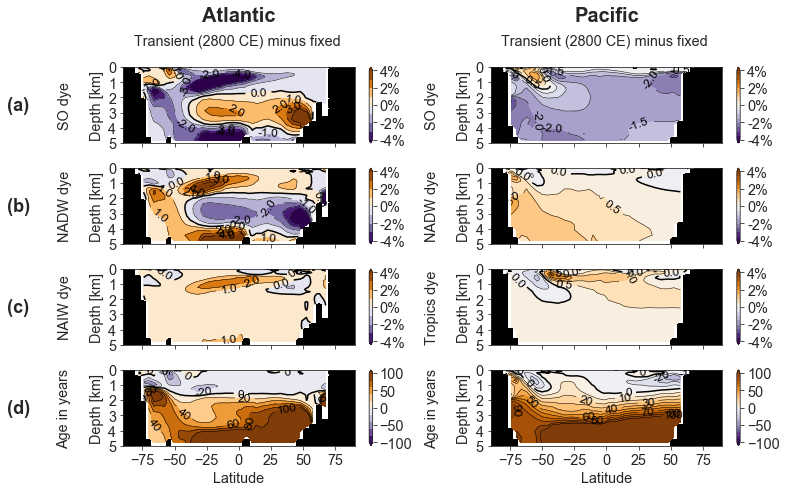

In [24]:
# Repeat dye and age at 2800 CE for Atl and Pac combined  ---- TAKES A WHILE ----

# SETTINGS:
t_step = -1   # take last time step: 2800 CE

# SEPARATE CONFIGURATIONS FOR 2800 CE because the larger changes at 2800 CE need a wider range
configs_2800 = {
    ('Atlantic','dye',True): ConfigContour(lo=-4, hi=4, levels=8, cmap='PuOr_r', 
                                           add_perc=True, extend='both', 
                                           anom_ticks=range(-4,5,2)), 
    ('Atlantic','age',True): ConfigContour(lo=-100, hi=100, levels=10, cmap='PuOr_r', 
                                           add_perc=False, extend='both', 
                                           anom_ticks=range(-100,110,50)), 
    ('Pacific','dye',True):  ConfigContour(lo=-4, hi=4, levels=16, cmap='PuOr_r', 
                                           add_perc=True, extend='both', 
                                           anom_ticks=range(-4,5,2)), 
    ('Pacific','age',True):  ConfigContour(lo=-100, hi=100, levels=20, cmap='PuOr_r', 
                                           add_perc=False, extend='both', 
                                           anom_ticks=range(-100,110,50)), 
}

# EXPLANATION:
# The rows contain multiple dye tracers and the last row is ideal age. The 3 columns are: 
# 1) fixed circulation at t1  2) transient circulation at t1  3) transient circulation at t2

# This time anoms=True is implicit so col 2 and 3 are anomalies w.r.t. fixed circulation

sns.set_style("ticks")
fig, ax = plt.subplots(len(row_vars),2, figsize=(11,7))

# abbreviate
obj_t = data_fulls[OcTRA]        # transient circulation
obj_f = data_fulls[OcFIX]        # fixed circulation
masks = data_fulls[OcTRA].masks  # basin masks incl SO sectors

### LOOP OVER ATLANTIC (COLUMN 1)
col = 0
ax[0,col].text(x=0.5, y=1.6, s='Atlantic', ha="center",
             transform=ax[0,col].transAxes, fontsize=20, fontweight='bold')

# DEFINE RELEVANT DYE TRACERS:
dyes = [6,1,2]      # atl-relevant dye water masses: SO, NADW, NAIW
# variables to be plotted on rows: multiple dye tracers and lastly ideal age (ida)
row_vars = ['Dye' + str(this_dye) for this_dye in dyes] + ['ida']

# PLOTTING:
create_land = True # keeps track of whether land is already created
for row, var in enumerate(row_vars):
    # var can be of type dye [% concentration] or ideal age [year]:
    if var[0:3] == 'Dye':
        var_type = 'dye' 
    elif var[0:3] == 'ida':
        var_type = 'age'
    else:
        raise Exception("Variable type '" + var[0:3] + "' unknown (not dye or ideal age).")

    ## prepare dye/age concentration objects:
    # slice the var to Atlantic basin and take zonal average (keeping depth, lat, time coords)
    conc_t = f.area_mean(obj_t, obj_t[var].where(masks==1), keep_lat=True, basin='atlso')
    conc_f = f.area_mean(obj_f, obj_f[var].where(masks==1), keep_lat=True, basin='atlso')

    ## create and plot land
    if create_land: 
        X, Y = np.meshgrid(obj_t.lat_u.values, obj_t.z_w.values)     # same for all subplots
        [land_mask, cmap_land] = f.create_land_mask(conc_t, obj_t)   # same for conc_t and conc_f
        for this_row in np.arange(0,len(row_vars)): 
            # add black land (color depends on vmin, vmax)
            ax[this_row,col].pcolormesh(X, Y, f.extend(land_mask), cmap=cmap_land, vmin=-0.5, 
                                        vmax=0.5) 
        create_land = False # only need to create land 1 time per basin

    ## plot
    title = "Transient (" + str(int(round(obj_t.time[t_step].item()))) + " CE) minus fixed \n"
    plot_obj = conc_t.isel(time=t_step) - conc_f.isel(time=t_step)
    c = configs_2800['Atlantic', var_type, True]  # anoms is always True for this figure 
    cbar = f.plot_contour(plot_obj, fig, ax=ax[row,col], var='CONC', levels=c.levels, 
                          hi=c.hi, lo=c.lo, title=title, cmap=c.cmap, add_perc=c.add_perc, 
                          extend=c.extend)
    # adjust colour bar
    cbar.set_ticks(c.anom_ticks)
    if c.add_perc:
        cbar.ax.set_yticklabels([str(n) + '%' for n in c.anom_ticks]) 
            
    # set dye labels (depends on basin)
    if var_type == 'dye':
        ax[row,col].set_ylabel('%s dye\n \nDepth [km]' %dye_labels[dyes[row]-1])

### LOOP OVER PACIFIC (COLUMN 2)
# we have 2 separate loops, because in the Atl the 3rd dye is NADW but in Pac it is Tropics dye
# CODE IS COPIED
col = 1
ax[0,col].text(x=0.5, y=1.6, s='Pacific', ha="center",
             transform=ax[0,col].transAxes, fontsize=20, fontweight='bold')

# DEFINE RELEVANT DYE TRACERS:
dyes = [6,1,8]      # pac-relevant dye water masses: SO, NADW, Tropics
# variables to be plotted on rows: multiple dye tracers and lastly ideal age (ida)
row_vars = ['Dye' + str(this_dye) for this_dye in dyes] + ['ida']

# PLOTTING:
create_land = True # keeps track of whether land is already created
for row, var in enumerate(row_vars):
    # var can be of type dye [% concentration] or ideal age [year]:
    if var[0:3] == 'Dye':
        var_type = 'dye' 
    elif var[0:3] == 'ida':
        var_type = 'age'
    else:
        raise Exception("Variable type '" + var[0:3] + "' unknown (not dye or ideal age).")

    ## prepare dye/age concentration objects:
    # slice the var to Pacific basin and take zonal average (keeping depth, lat, time coords)
    conc_t = f.area_mean(obj_t, obj_t[var].where(masks==2), keep_lat=True, basin='pacso')
    conc_f = f.area_mean(obj_f, obj_f[var].where(masks==2), keep_lat=True, basin='pacso')

    ## create and plot land
    if create_land: 
        X, Y = np.meshgrid(obj_t.lat_u.values, obj_t.z_w.values)     # same for all subplots
        [land_mask, cmap_land] = f.create_land_mask(conc_t, obj_t)   # same for conc_t and conc_f
        for this_row in np.arange(0,len(row_vars)): 
            # add black land (color depends on vmin, vmax)
            ax[this_row,col].pcolormesh(X, Y, f.extend(land_mask), cmap=cmap_land, vmin=-0.5, 
                                        vmax=0.5) 
        create_land = False # only need to create land 1 time per basin

    ## plot
    title = "Transient (" + str(int(round(obj_t.time[t_step].item()))) + " CE) minus fixed \n"
    plot_obj = conc_t.isel(time=t_step) - conc_f.isel(time=t_step)
    c = configs_2800['Pacific', var_type, True]  # anoms is always True for this figure 
    cbar = f.plot_contour(plot_obj, fig, ax=ax[row,col], var='CONC', levels=c.levels, 
                          hi=c.hi, lo=c.lo, title=title, cmap=c.cmap, add_perc=c.add_perc, 
                          extend=c.extend)
    # adjust colour bar
    cbar.set_ticks(c.anom_ticks)
    if c.add_perc:
        cbar.ax.set_yticklabels([str(n) + '%' for n in c.anom_ticks]) 
            
    # set dye labels (depends on basin)
    if var_type == 'dye':
        ax[row,col].set_ylabel('%s dye\n \nDepth [km]' %dye_labels[dyes[row]-1])

## TICKS AND LABELS
for row in np.arange(0,len(row_vars)):
    ax[row,0].text(-0.5, 0.5, '(' + chr(ord('a')+row) + ')', transform=ax[row,0].transAxes, 
                   size=18, weight='bold', va='center')
    for col in [0,1]:
        ax[row,col].set_xticks(range(-75,80,25))
        if row != (len(row_vars)-1):
            ax[row,col].set_xlabel('') # overwrite
            ax[row,col].set_xticklabels("") # delete tick labels again if not in last row
        if row != 0:
            ax[row,col].set_title("") # delete titles on all rows except top row
        if row == len(row_vars)-1: # other ylabels (for dye) already defined above for each basin
            ax[row,col].set_ylabel("Age in years\n\nDepth [km]")
            
plt.tight_layout()
plt.savefig(savedir / 'AppFig03_dye_and_age_2800_anoms.pdf')

<a id='setup-sensitivity'></a>

# F) Sensitivity of leads and lags
# Set up sensitivity
[go to top](#top)

In [25]:
# load all sensitivity runs
# implicitly still using small or large files according to data_mode setting under Set up notebook
runs = [OcTRA, OcFIX, OcTRA_strongmix, OcFIX_strongmix, OcTRA_weakmix, OcFIX_weakmix, 
        OcTRA_strongwind, OcFIX_strongwind, OcTRA_weakwind, OcFIX_weakwind]
labels = {OcTRA: 'STD TRA', OcFIX: 'STD FIX', 
          OcTRA_strongmix: 'strong_mix TRA', OcFIX_strongmix: 'strong_mix FIX', 
          OcTRA_weakmix: 'weak_mix TRA', OcFIX_weakmix: 'weak_mix FIX', 
          OcTRA_strongwind: 'strong_wind TRA', OcFIX_strongwind: 'strong_wind FIX', 
          OcTRA_weakwind: 'weak_wind TRA', OcFIX_weakwind: 'weak_wind FIX'}

[datas, data_fulls] = f.load_data_multiple_runs(datadir, runs, spinup_yr)
for run in runs:
    for obj in [datas, data_fulls]: 
        # convert depth to km:
        obj[run]['z_t'] = obj[run]['z_t'] / 1000.0
        obj[run]['z_w'] = obj[run]['z_w'] / 1000.0
        # convert simulation time to time CE
        obj[run]['time'] += 1200

<a id='appfig4'></a>

# Appendix Figure 4
[go to top](#top)

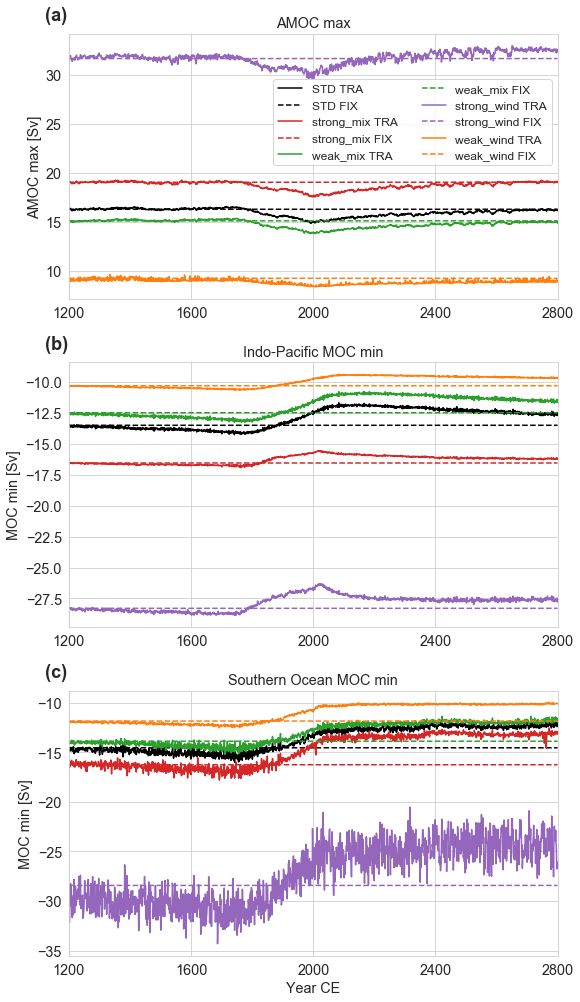

In [26]:
# timeseries of MOC for sensitivity runs
sns.set_style("whitegrid")
fig, ax = plt.subplots(3, figsize=(8,14))

time = datas[OcFIX_strongmix].time  # using that all simulations have the same output frequency

cols = ['k', 'k', 'C3', 'C3', 'C2', 'C2', 'C4', 'C4', 'C1', 'C1']
lines = ['solid', 'dashed', 'solid', 'dashed', 'solid', 'dashed', 'solid', 'dashed',
         'solid', 'dashed']
for i, run in enumerate(runs):
    ax[0].plot(time, datas[run].OPSIA_max, cols[i], label=labels[run], linestyle=lines[i]) 
    ax[1].plot(time, datas[run].OPSIP_min, cols[i], label=labels[run], linestyle=lines[i]) 
    ax[2].plot(time, datas[run].OPSIS_min, cols[i], label=labels[run], linestyle=lines[i]) 

ax[0].set_ylabel('AMOC max [Sv]')
ax[0].set_title('AMOC max')
ax[1].set_ylabel('MOC min [Sv]')
ax[1].set_title('Indo-Pacific MOC min')
ax[2].set_ylabel('MOC min [Sv]')
ax[2].set_title('Southern Ocean MOC min')
ax[2].set_xlabel('Year CE')

ax[0].legend(ncol=2, fontsize=12, loc='upper right', bbox_to_anchor=(1.0,0.85)) 
# bbox sets upper right corner at this xy

for n,axis in enumerate(ax):
    axis.set_xlim(1200,2800)
    axis.set_xticks(range(1200,2900,400))
    ax[n].text(-0.05, 1.05, '(' + chr(ord('a')+n) + ')', transform=ax[n].transAxes, 
               size=18, weight='bold')
plt.tight_layout(h_pad=1.7)

plt.savefig(savedir / 'AppFig04_amoc_all.pdf')

<a id='appfig5'></a>

# Appendix Figure 5
[go to top](#top)

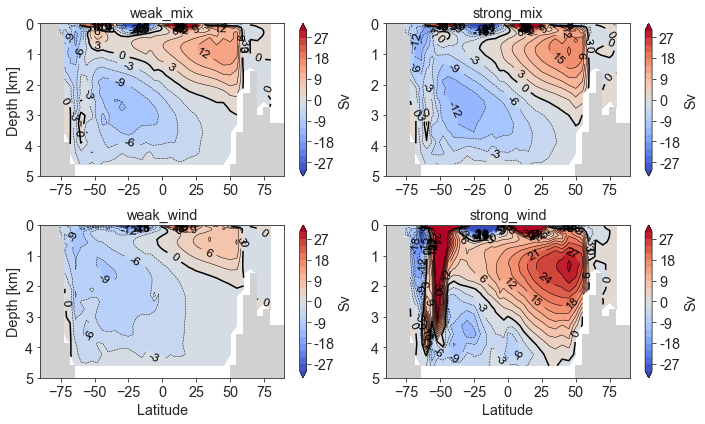

In [27]:
# Global overturning for all simulations combined
# Note that it doesn't matter whether we plot TRA or FIX since we plot at steady state (t=0)

# SETTINGS:
levels = 20      # number of contours
hi = 30          # max of colourbar
lo = -30         # min of colourbar
time_avg = True  # average over 15 years instead of taking 1 year

sns.set_style("ticks")
fig, ax = plt.subplots(2,2, figsize=(10,6))

# set 4 runnames in the wanted plot sequence of 2x2 subplots:
runs_seq = np.asarray([[OcFIX_weakmix, OcFIX_strongmix],
                       [OcFIX_weakwind, OcFIX_strongwind]])
for row in [0,1]:
    for col in [0,1]:
        this_run = runs_seq[row,col]      # abbreviate
        data_full = data_fulls[this_run]  # abbreviate

        # find global overturning
        opsi_all_t = data_full.OPSI + data_full.GMOPSI  # still contains time coord t
        
        if time_avg:
            # over 30 yrs e.g. 1750 now becomes average over [1735, 1765] 
            # but here t=0 so only 15 yrs to be consistent with Fig. 3 column 1 
            # and also to avoid forced period after 1223 CE
            opsi = opsi_all_t.sel(time=slice(1200,1222)).mean(dim='time') # takes [1205, 1220]
        else:
            opsi = opsi_all_t.isel(time=0).item()
        
        # LAND:
        # we want to replace 0 values (land) by nan values such that 
        # the opsi variables are not plotted on land & the nan values are needed to plot land
        opsi = opsi.where(opsi != 0.0, np.nan)
        [mask_gl, cmap_land_gl] = f.create_land_mask(opsi, data_full) 
        X, Y = np.meshgrid(data_full.lat_u.values, data_full.z_w.values) # same for all subplots    

        this_title = labels[this_run] 
        # light grey land 
        ax[row,col].pcolormesh(X, Y, mask_gl, cmap=cmap_land_gl, vmin=0.8, vmax=1.5)
        f.plot_contour(opsi, fig, ax=ax[row,col], levels=levels, lo=lo, hi=hi, var='OPSI', 
                       extend='both', title=this_title[:-4]) # drop ' TRA' endings in title
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_xticks(range(-75,80,25))
        if i==0:
            ax[i,j].set_xlabel("")  # overwrite plotting function with empty label
        if j==1:
            ax[i,j].set_ylabel("")
            
plt.tight_layout()
plt.savefig(savedir / 'AppFig05_overturning_global_all.pdf')

<a id='fig10'></a>

# Figure 10
[go to top](#top)

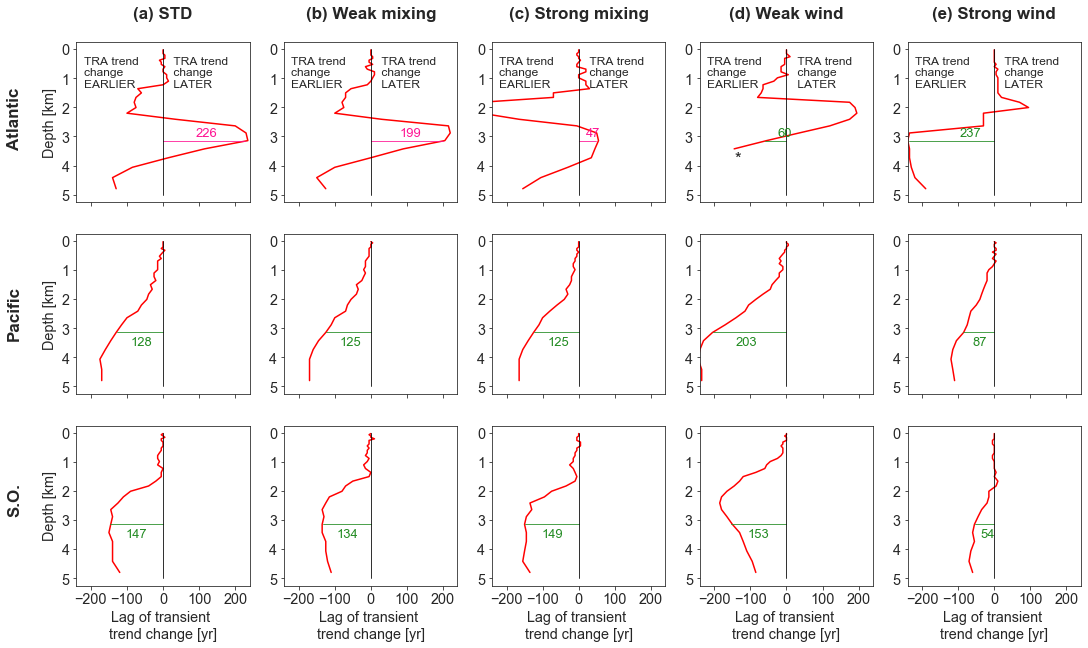

In [28]:
# Lag of trend change over depth for sensitivity simulations   ------- TAKES A WHILE ---------

# SETTINGS:
# order of run_pairs must be same as order of titles below & TRA before FIX
run_pairs = [[OcTRA, OcFIX],
             [OcTRA_weakmix, OcFIX_weakmix], 
             [OcTRA_strongmix, OcFIX_strongmix],
             [OcTRA_weakwind, OcFIX_weakwind],
             [OcTRA_strongwind, OcFIX_strongwind]]

sns.set_style("ticks")     
fig, ax = plt.subplots(3,5, figsize=(18,10))

# TITLES
ax[0,0].set_title("(a) STD\n", fontweight='bold', fontsize=17)
ax[0,1].set_title("(b) Weak mixing\n", fontweight='bold', fontsize=17)
ax[0,2].set_title("(c) Strong mixing\n", fontweight='bold', fontsize=17)
ax[0,3].set_title("(d) Weak wind\n", fontweight='bold', fontsize=17)
ax[0,4].set_title("(e) Strong wind\n", fontweight='bold', fontsize=17)

def lag_color(lead):
    """Gives color of leads/lags annotation depending on sign 
    (color can be used for horizontal line and nr of years)."""
    # definition: lag = - lead
    if lead >= 0.0: 
        return 'forestgreen'  # negative lag
    elif lead < 0.0:
        return 'deeppink'     # positive lag

for col, [run_t, run_f] in enumerate(run_pairs):
    ## CALCULATIONS ----------------------------------------------------------------
    # prepare temperature anomaly data per basin:
    [pac_t, pac_f, atl_t, atl_f, so_t, so_f] = f.temp_basin(data_fulls[run_t], data_fulls[run_f])

    # find ridges (old term for red lines in Fig 4)
    ridge_atl_t = f.find_ridges(atl_t, only_min=True, min_guess=1750.0, fast=True)
    ridge_atl_f = f.find_ridges(atl_f, only_min=True, min_guess=1750.0, fast=True)
    ridge_pac_t = f.find_ridges(pac_t, only_min=True, min_guess=1750.0, fast=True)
    ridge_pac_f = f.find_ridges(pac_f, only_min=True, min_guess=1750.0, fast=True)
    ridge_so_t  = f.find_ridges(so_t,  only_min=True, min_guess=1750.0, fast=True)
    ridge_so_f  = f.find_ridges(so_f,  only_min=True, min_guess=1750.0, fast=True)
    
    # No values for ridge_atl_f are found below ca. 3.5 km for OcFIX_weakwind
    # Apparently (only) in this case the LIA cooling is not detectable at this depth
    # We hard-code that these wrong values (of 1205 CE) are set to nan to avoid weird jump to 1200
    ridge_atl_f[ridge_atl_f < 1700.0] = np.nan

    # find the lead: only use the 5th object (this is the lead)
    lead_atl = f.calc_leads_lags(atl_t, atl_f)[4]
    lead_pac = f.calc_leads_lags(pac_t, pac_f)[4]
    lead_so = f.calc_leads_lags(so_t, so_f)[4]

    ## PLOTTING -------------------------------------------------------------------
    # plot difference in timing of transient minus fixed minimum temperature anomaly 
    # (analagous to Fig 4c = difference of the red lines in Fig 4a-b; now for sensitivity runs)
    z_t = atl_t.z_t.values
    ax[0,col].plot(ridge_atl_t - ridge_atl_f, z_t, 'r') 
    ax[1,col].plot(ridge_pac_t - ridge_pac_f, z_t, 'r') 
    ax[2,col].plot(ridge_so_t - ridge_so_f, z_t, 'r') 

    # annotate leads with horizontal line and number of years
    # grid cell is at 3142 m
    ax[0,col].plot([-lead_atl,0], [3.14,3.14], linewidth=0.8, color=lag_color(lead_atl)) 
    ax[1,col].plot([-lead_pac,0], [3.14,3.14], linewidth=0.8, color=lag_color(lead_pac))
    ax[2,col].plot([-lead_so,0], [3.14,3.14], linewidth=0.8, color=lag_color(lead_so))
    ax[0,col].text(x=-lead_atl*0.4, y=3.0, s=str(abs(lead_atl)), color=lag_color(lead_atl),
                   fontsize=13)
    ax[1,col].text(x=-lead_pac*0.7, y=3.6, s=str(abs(lead_pac)), color=lag_color(lead_pac),
                   fontsize=13)
    ax[2,col].text(x=-lead_so*0.7, y=3.6, s=str(abs(lead_so)), color=lag_color(lead_so),
                   fontsize=13)

# TICKS, LABELS, VERTICAL ZERO LINE, ANNOTATIONS
for i in range(0,3):
    for j in range(0,5):
        # vertical zero line:
        ax[i,j].plot([0,0], [0,5], linewidth=0.8, color='k')
        if i==0:
            # annotations inside plot panel:
            ax[i,j].text(x=-220, y=1.3, s='TRA trend\nchange \nEARLIER', fontsize=12)
            ax[i,j].text(x=20, y=1.3, s=' TRA trend\n change \n LATER', fontsize=12)    
        # ticks and labels:
        ax[i,j].set_xlim(-240,240)
        ax[i,j].set_xticks(range(-200,210,100))
        ax[i,j].set_yticks(range(0, 6, 1))
        ax[i,j].invert_yaxis() # depth goes down on y axis
        if i == 2:
            ax[i,j].set_xlabel("Lag of transient \ntrend change [yr]")
        else:
            ax[i,j].set_xticklabels("") # remove labels for a more quiet view (ticks remain)
        if j == 0:
            ax[i,j].set_ylabel("Depth [km]")

# ANNOTATE BASINS
ax[0,0].text(x=-0.4, y=0.35, s="Atlantic", transform=ax[0,0].transAxes, 
             fontsize=17, fontweight='bold', rotation=90)
ax[1,0].text(x=-0.4, y=0.35, s="Pacific", transform=ax[1,0].transAxes, 
             fontsize=17, fontweight='bold', rotation=90)
ax[2,0].text(x=-0.4, y=0.45, s="S.O.", transform=ax[2,0].transAxes, 
             fontsize=17, fontweight='bold', rotation=90)

# place a star about hard-coding away jump as a footnote to refer to in Figure caption
ax[0,3].text(x=0.2, y=0.24, s="*", transform=ax[0,3].transAxes, fontsize=17)

plt.savefig(savedir / "Fig10_sensitivity_lags_vs_depth.pdf")

*No values for ridge_atl_f are found below ca. 3.5 km for OcFIX_weakwind.  
Apparently (only) in this case the LIA cooling is not detectable at this depth.  
We hard-code that these wrong values (of 1205 CE) are set to nan such that they are not plotted as a weird jump (artefact).*  

<a id='fig11'></a>

# G) Comparison to Gebbie & Huybers (2019)

- Gebbie, G. and Huybers, P.: The Little Ice Age and 20th-century deep Pacific cooling, Science, 363, 70–74,
https://doi.org/10.1126/science.aar8413, 2019

Referred to in the following as Gebbie & Huybers 2019.

# Figure 11
[go to top](#top)

This Figure is the analogue of Fig 2 in Gebbie & Huybers 2019 science, such that we can compare our results with theirs around 2 km depth. There is a small difference in grid cell boundaries (we: 1912-2520m; they: 1800-2600m depth).  
I couldn't find their colormap in the standard libraries so first we make a colormap as similar to theirs as possible:

In [29]:
# DEFINE COLORMAP
# using color names from https://matplotlib.org/3.1.0/gallery/color/named_colors.html
# for smooth gradients, every color appears twice, with position of its center in between
# specific shades of, resp.: blue, blue, blue, blue, green, yellow, orange, red
c = matplotlib.colors.ColorConverter().to_rgb
gebbie_huybers = f.make_colormap(
    [c('darkslateblue'), c('slateblue'), 0.14, c('slateblue'), c('royalblue'), 0.16, 
     c('royalblue'), c('lightskyblue'), 0.36, c('lightskyblue'), c('beige'), 0.52, 
     c('beige'), c('moccasin'), 0.59, c('moccasin'), c('sandybrown'), 0.68, 
     c('sandybrown'), c('firebrick')])

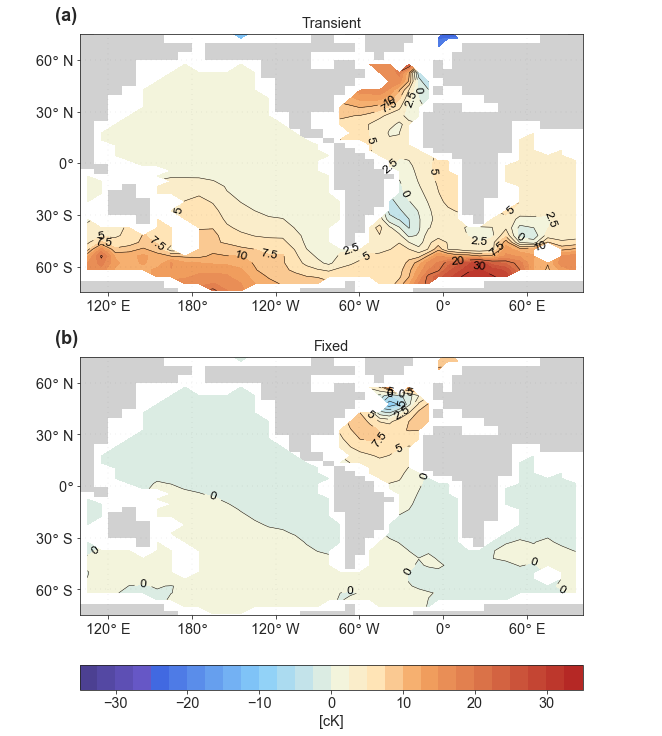

In [30]:
# TEMPERATURE AROUND 2 KM (comparison with Gebbie & Huybers 2019, Fig 2)

# SETTINGS: -----------------------
contours = True  # as contour plot (Fig 11); otherwise real values are plotted as pixels

# This Figure is a depth average between d1 and d2 & a time anomaly between t2_woce and t1_chal
# Depth average between 1912 m (w-grid upper boundary) and 2520 m (w-grid lower boundary):

d1 = 21        # 1912 m on w-grid (upper boundary); 2004 m on T-grid (centered)
d2 = 23        # d2+1 gives 2520 m on w-grid (lower boundary); 2409 m on T-grid
t1_chal = 134  # 1875, chosen as time of Challenger expedition (1872-1876)
t2_woce = 158  # 1995, chosen as time of WOCE (1990-2003)  
# being careful here not to overwrite the global time steps of interest t1, t2

# as in Gebbie & Huybers 2019:
cmap = gebbie_huybers   # color map defined above
hi = 35.0               # max of colorbar [cK]
lo = -35.0              # min of colorbar [cK]
levels = 28             # number of contours between hi,lo

# END OF SETTINGS -----------------

sns.set_style('ticks')
fig, ax = plt.subplots(2, figsize=(9, 10.35))

## PREPARE COORDINATES
delta_z = np.diff(data_fulls[OcTRA].z_t[d1:d2+2]) # in km for the 3 cells from 1912 to 2520m
# why +2? +1 because [] excludes last; +1 because we need lower w-boundary

xu = data_fulls[OcTRA].lon_u
yu = data_fulls[OcTRA].lat_u

## create land mask according to the surface (taking shallowest depth d1 looked strange)
X, Y = np.meshgrid(xu, yu)
[land_mask, cmap_land] = f.create_land_mask(data_fulls[OcTRA].TEMP.isel(time=0, z_t=0),
                                            data_fulls[OcTRA])

# circulation type: transient (row 1), fixed (row 2)
for n,run in enumerate([OcTRA, OcFIX]):   
    if n == 0:
        circ_str = 'Transient'
    elif n == 1:
        circ_str = 'Fixed'

    # add land (same grey as in our Fig 2: vmin=0.8,vmax=1.5; for black: vmin=0.5,vmax=1.5)
    ax[n].pcolormesh(X, Y, f.extend(land_mask), cmap=cmap_land, vmin=0.8, vmax=1.5, zorder=0)

    temp_t1 = data_fulls[run].TEMP.isel(time=t1_chal)  # temperature in Celsius
    temp_t2 = data_fulls[run].TEMP.isel(time=t2_woce)  

    # depth slices
    t1_slice = temp_t1.isel(z_t=slice(d1, d2+1)) # +1 because slicing excludes last
    t2_slice = temp_t2.isel(z_t=slice(d1, d2+1)) 

    # 1). AVERAGE OVER 3 DEPTH CELLS
    res_t1 = np.average(t1_slice, axis=0, weights=delta_z) # depth is on axis 0
    res_t2 = np.average(t2_slice, axis=0, weights=delta_z)
    # using np.average since it has a convenient weighted-average (xr.mean() does not) 
    # but we loose the xarray data structure. Converting back to xarray:
    res_t1 = xr.DataArray(res_t1, coords=[data_fulls[run].lat_t, data_fulls[run].lon_t],
                          dims=['lat_t', 'lon_t'])
    res_t2 = xr.DataArray(res_t2, coords=[data_fulls[run].lat_t, data_fulls[run].lon_t],
                          dims=['lat_t', 'lon_t'])

    # 2). PLOT DIFFERENCE BETWEEN THE 2 TIME STEPS
    plot_obj = (res_t2 - res_t1) * 100  # convert to cK
    if contours:    
        # plot as contour levels
        X, Y = np.meshgrid(xu, yu)
        cpf = f.plot_contour(plot_obj, fig, ax=ax[n], var='TEMP', levels=levels, hi=hi, lo=lo,
                             cbar=False, title=circ_str, cmap=cmap, extend='neither')
    else:
        # plot as pixels with real values
        [ax[n], cpf] = f.plot_surface(fig, ax[n], xu, yu, plot_obj, title=circ_str, cbar=False, 
                                      cbar_label='[cK]', cmap=cmap, vmin=lo, vmax=hi,
                                      ticklabels=True)

    # ticks and labels as in Gebbie & Huybers 2019
    ax[n].set_yticks(range(-60,70,30))
    ax[n].set_ylim(-75,75)
    deg = r"$\degree$" # abbreviate & below we use only 1 font (default) and latex for symbols 
    ax[n].set_yticklabels(['60'+deg+' S', '30'+deg+' S', '0'+deg, '30'+deg+' N', '60'+deg+' N'])
    ax[n].set_xticks(range(120,430,60)) # on Bern3D longitude axis: interval [100, 460]
    ax[n].set_xticklabels(['120'+deg+' E', '180'+deg, '120'+deg+' W', 
                           '60'+deg+' W', '0'+deg, r'60'+deg+' E'])
    ax[n].grid(True, linestyle='dashed', dashes=[5.6,45], linewidth=0.1, c='k') # grid on top
    ax[n].text(-0.05, 1.05, '(' + chr(ord('a')+n) + ')', transform=ax[n].transAxes,
               size=18, weight='bold')

# PLOT COLORBAR
# make room for cbar & set height between subplots because tight_layout breaks down now
fig.subplots_adjust(bottom=0.1, hspace=0.25)
# add colorbar on new axis (otherwise changes ratio of one subplot)
ax_cbar = fig.add_axes([0.012, 0, 1.0, 0.225]) # x0,y0 (lower left),w,h; width controls cbar size
ax_cbar.axis('off')
cbar = fig.colorbar(cpf, ax=ax_cbar, label='[cK]', orientation='horizontal')
cticks = range(-30,31,10)
cbar.set_ticks(cticks)

if contours:
    plt.savefig(savedir / 'Fig11_temperature_around_2km.pdf')
else:
    plt.savefig(savedir / 'NOT_USED_temperature_around_2km_pixels.pdf')    

<a id='calc-appB'></a>

# H) Appendix
# Appendix B: Quantification of effects causing leads and lags at 3 km
- In the following, we compute the values that are listed in the tables of Appendix B of scheen20esd and print all of these in print statements.  
- Note that often not all values are used in the tables of Appendix B hence not all values are printed. But they can be easily retrieved from the variables computed below. For example, if only the contributions of water masses NADW and SO are printed, then the contribution of NPIW could be printed using the same object.  
- Regarding documentation: methods are explained in Appendix B, although we briefly repeat the most important equations below (without explanation).  
- We use 'a' and 'age' and 'ideal age (ida)' as synonyms.  

[effect 1: changing SST](#eff1)  
[effect 2a: changing water masses](#eff2a)  
[effect 2b: changing water age](#eff2b)  
[interaction](#int)  
[total](#tot)  
[residual](#res)  
[uncertainty](#unc)

[go to top of notebook](#top)   

In [31]:
## load in the appropiate variables of OcTRA and OcFIX
# depending on data mode setting (chosen on top of notebook)

if data_mode == "_small":
    OcTRA = 'OcTRA_medium'  # especially made for Appendix B
    OcFIX = 'OcFIX_small'   # only needs TEMP variable so _small is good enough
    runs = [OcTRA, OcFIX]
    
    [datas, data_fulls] = f.load_data_multiple_runs(datadir, runs, spinup_yr)
    for run in runs:
        for obj in [datas, data_fulls]: 
            # convert depth to km:
            obj[run]['z_t'] = obj[run]['z_t'] / 1000.0
            obj[run]['z_w'] = obj[run]['z_w'] / 1000.0
            # shift simulation time to time CE
            obj[run]['time'] += 1200 
# elif data_mode == "": nothing needed, large versions of both OcTRA, OcFIX are already loaded
elif data_mode != "":
    raise Exception("data_mode in which to load data is not set properly (under Set up notebook).")

<a id='eff1'></a>

### Effect 1 (changing SST):
[go to top of notebook](#top)  
[go to top of Appendix B](#calc-appB) 

We follow Eq. (B1), namely:

In [32]:
%%latex
\begin{align*}
    \Delta T_\mathrm{SST}~(t^*) ~\approx~
    \frac{1}{a_\mathrm{max}(t_0) - a_\mathrm{min}(t_0)}~
    \sum_{i=1}^8 ~ f_i(t_0) ~~ 
    \int_{t^*-a_\mathrm{max}(t_0)}^{t^*-a_\mathrm{min}(t_0)} \Delta T_i(t) ~ dt
\end{align*}

<IPython.core.display.Latex object>

In [33]:
# Recall that the order of dye tracers in output (Dye1, Dye2 etc.) is given by dye_labels.
# This is repeated here:
dye_labels
# [Dye1, Dye2, ..., Dye8]

['NADW', 'NAIW', 'SAIW', 'NPIW', 'SPIW', 'SO', 'Arctic', 'Tropics']

In [34]:
## find water mass fractions f[i](t0)

f_t0_atl = {}  # f_i(t0) for Atlantic; keys will be the dye tracer names from dye_labels
f_t0_pac = {}
f_t0_so = {}

vol = data_fulls[OcTRA].boxvol.transpose('lat_t','lon_t','z_t')
# transposed because boxvol has coordinates in another order than Dye output for some reason
mask = data_fulls[OcTRA].mask

t = 0   # we evaluate f[i] at t=t0 for effect 1

# n is a number 0,..,7 and i is the dye string
for n, i in enumerate(dye_labels):  
    # slice dye tracer to 3.1 km depth, time step t and basin; still keep lat,lon
    f_atl_2D = data_fulls[OcTRA]['Dye'+str(n+1)].isel(z_t=26, time=t).where(mask==1) 
    f_pac_2D = data_fulls[OcTRA]['Dye'+str(n+1)].isel(z_t=26, time=t).where(mask==2) 
    f_so_2D = data_fulls[OcTRA]['Dye'+str(n+1)].isel(z_t=26, time=t).where(mask==4) 
        
    # average over lat, lon and go from % to fraction
    f_t0_atl[i] = f.vol_mean(f_atl_2D, vol) / 100.0
    f_t0_pac[i] = f.vol_mean(f_pac_2D, vol) / 100.0 
    f_t0_so[i] = f.vol_mean(f_so_2D, vol) / 100.0
    
# print the fractions that are used in Table B1 (only NADW, SO)
for i in ['NADW', 'SO']:  
    print("Atl  f_"+i+"(t0): ", round(f_t0_atl[i], 3))
    print("Pac  f_"+i+"(t0): ", round(f_t0_pac[i], 3))
    print("S.O. f_"+i+"(t0): ", round(f_t0_so[i], 3), "\n")

Atl  f_NADW(t0):  0.58
Pac  f_NADW(t0):  0.149
S.O. f_NADW(t0):  0.157 

Atl  f_SO(t0):  0.307
Pac  f_SO(t0):  0.78
S.O. f_SO(t0):  0.788 



In [35]:
# check that sum of all dye tracers is close to 1 for each basin 
sum(f_t0_pac.values()), sum(f_t0_atl.values()), sum(f_t0_so.values())

(0.9980345835034138, 0.9990811572624085, 0.9992494948122501)

In [36]:
# check that variables t2, t3 still correspond to t*=1750 resp. t*=2000 CE
data_fulls[OcTRA].time[t2].item(), data_fulls[OcTRA].time[t3].item()

(1749.5000000010032, 1999.5000000014593)

In [37]:
## find a_min(t0), a_max(t0) from ideal age 'a'

mask = data_fulls[OcTRA].mask

age_atl = data_fulls[OcTRA].ida.where(mask==1) # Atlantic excl SO
age_pac = data_fulls[OcTRA].ida.where(mask==2) # Pacific excl SO
age_so = data_fulls[OcTRA].ida.where(mask==4)  # Southern Ocean (SO)

def age_min_max(age_obj, t, d=26):
    """Returns [age_min, age_max] in years at time step t and depth d. 
    Default depth is 3.1 km (depth step 26). """
    d_t_slice = age_obj.isel(time=t, z_t=d)
    return [round(d_t_slice.min().item()), round(d_t_slice.max().item())] # in entire years

# compute a_min(t0), a_max(t0) where t0 = 1200, start of simulation
[a_min_atl_t0, a_max_atl_t0] = age_min_max(age_atl, t=0)
[a_min_pac_t0, a_max_pac_t0] = age_min_max(age_pac, t=0)
[a_min_so_t0, a_max_so_t0] = age_min_max(age_so, t=0)

# print the ages (used in Table B1)
print("Atl  a_min(t0): ", a_min_atl_t0, " yr")
print("Pac  a_min(t0): ", a_min_pac_t0, " yr")
print("S.O. a_min(t0): ", a_min_so_t0, " yr\n")
print("Atl  a_max(t0): ", a_max_atl_t0, " yr")
print("Pac  a_max(t0): ", a_max_pac_t0, " yr")
print("S.O. a_max(t0): ", a_max_so_t0, " yr")

Atl  a_min(t0):  13  yr
Pac  a_min(t0):  528  yr
S.O. a_min(t0):  252  yr

Atl  a_max(t0):  746  yr
Pac  a_max(t0):  1397  yr
S.O. a_max(t0):  885  yr


In [38]:
## find water mass temperature history, delta_T[i](t)

# as typical water mass temperature we take the surface temperature in its area of origin
# thus the notation T[i] actually means SST[i]

sst = data_fulls[OcTRA].TEMP.isel(z_t=0)
T = {}        # time series of temperature for each water mass i; keys are dye_labels i
delta_T = {}  # idem but anomaly

for i in dye_labels:
    T[i] = f.area_mean_dye_regions(sst, data_fulls[OcTRA].boxvol, region=i)
    delta_T[i] = T[i] - T[i].isel(time=0)  # to anomalies

Now we will perform the average = 1/(a_max-a_min) * integral delta_T_i(t) dt.  
In the implementation we will use .mean() and slicing [ : ] to simplify the integral, as shown in pseudo-code in the second line of the equation:

In [39]:
%%latex
\begin{align*}   
    \Delta T_\mathrm{SST}~(t^*) ~\approx~&
    \frac{1}{a_\mathrm{max}(t_0) - a_\mathrm{min}(t_0)}~
    \sum_{i=1}^8 ~ f_i(t_0) ~~ 
    \int_{t^*-a_\mathrm{max}(t_0)}^{t^*-a_\mathrm{min}(t_0)} \Delta T_i(t) ~ dt \\
    ~\approx~& 
    \sum_{i=1}^8 ~ f_i(t_0) \cdot 
    \Delta T_{i} [t^*-a_\mathrm{max}(t_0) : t^*-a_\mathrm{min}(t_0)].\mbox{mean()}
\end{align*}

<IPython.core.display.Latex object>

In [40]:
## perform average = 1/(a_max-a_min) * integral delta_T[i](t) dt 
# using .mean() and slicing as in pseudo-code formula above

def avg_delta_T_i(delta_T_i, a_min, a_max, t_star):
    """This function averages delta_T_i(t) over time interval [t_star-a_max, t_star-a_min].
    Input:
    - delta_T_i must be a time series (no other coords) of temperature anomaly of water mass i
    - a_min and a_max are minimum and maximum ideal age in the basin of interest
    - t_star (integer) is the time of interest as a time step index
    Output:
    - average of delta_T_i(t) over time interval mentioned above. This equals:
      1/(a_max-a_min) * integral delta_T_i(t) dt   (over interval mentioned above)
    Author: Jeemijn Scheen, jeemijn.scheen@climate.unibe.ch"""

    if a_min >= a_max:
        raise Exception("a_min should be smaller than a_max.")
    
    # ASSUMPTION: output frequency is 5 yr (see data_full.time)
    delta_a = 5.0  # delta_a=delta_t, same step size because 'a' output based on output time freq
    # express a_min, a_max in nr. of time steps
    a_min = int(round(a_min / delta_a)) 
    a_max = int(round(a_max / delta_a)) 
    
    # NOTE: t_star (time step of interest) vs t_start (lower boundary of integral)
    t_start = t_star - a_max
    t_end = t_star - a_min
    
    # result in degree Celsius for 3 cases: 
    # taking t=0 (steady state) instead for the part that lies before start of simulation
    if t_start > 0 and t_end > 0:
        # A) t_start and t_end are both after start of simulation
        # => average over whole interval [t_start, t_end]
        return delta_T_i[t_start:t_end+1].mean().item() 
    elif t_start <= 0 and t_end <= 0:
        # B) t_start and t_end are both before start of simulation
        # => average boils down to taking value at t0
        return delta_T_i.isel(time=0).item()
    elif t_start <= 0 and t_end > 0:
        # C) t_start before start of simulation and t_end after start
        # => take linear combination of 2 subintervals with corresponding weight
        
        # => take value at t0 for subinterval [t_start, 0]
        res_1 = delta_T_i.isel(time=0).item()
        weight_1 = abs(t_start) / (t_end - t_start)
        # => take average over subinterval [0, t_end]
        res_2 = delta_T_i[0:t_end+1].mean().item()
        weight_2 = t_end / (t_end - t_start)
        
        return res_1 * weight_1 + res_2 * weight_2
    # else t_end < t_start (does not occur)
    
# define dictionaries for result of averaging delta_T_i per basin and t*
delta_T_bar_atl_1750 = {}
delta_T_bar_pac_1750 = {}
delta_T_bar_so_1750  = {}
delta_T_bar_atl_2000 = {}
delta_T_bar_pac_2000 = {}
delta_T_bar_so_2000  = {}
# perform averaging for each case, via function
for i in dye_labels:
    # bar stands for horizontal bar on top in latex i.e. the averaging is done; in degree C
    delta_T_bar_atl_1750[i] = avg_delta_T_i(delta_T[i], a_min_atl_t0, a_max_atl_t0, t2)
    delta_T_bar_pac_1750[i] = avg_delta_T_i(delta_T[i], a_min_pac_t0, a_max_pac_t0, t2)
    delta_T_bar_so_1750[i]  = avg_delta_T_i(delta_T[i], a_min_so_t0, a_max_so_t0, t2)
    delta_T_bar_atl_2000[i] = avg_delta_T_i(delta_T[i], a_min_atl_t0, a_max_atl_t0, t3)
    delta_T_bar_pac_2000[i] = avg_delta_T_i(delta_T[i], a_min_pac_t0, a_max_pac_t0, t3)
    delta_T_bar_so_2000[i]  = avg_delta_T_i(delta_T[i], a_min_so_t0, a_max_so_t0, t3)
    
# print averaged temperature anomalies that are used in Table B1 (only NADW, SO & only 2000 CE)
for i in ['NADW', 'SO']:  
    print("Atl  delta_T_"+i+"_bar(2000): ", round(delta_T_bar_atl_2000[i], 4), " C")
    print("Pac  delta_T_"+i+"_bar(2000): ", round(delta_T_bar_pac_2000[i], 5), " C")
    print("S.O. delta_T_"+i+"_bar(2000): ", round(delta_T_bar_so_2000[i], 4), " C\n")

Atl  delta_T_NADW_bar(2000):  -0.0242  C
Pac  delta_T_NADW_bar(2000):  0.00948  C
S.O. delta_T_NADW_bar(2000):  -0.0535  C

Atl  delta_T_SO_bar(2000):  -0.0419  C
Pac  delta_T_SO_bar(2000):  -0.00662  C
S.O. delta_T_SO_bar(2000):  -0.0603  C



In [41]:
## combine to final result for effect 1 

# take  sum_i f_i_t0 * delta_T_i_bar(t*)  for each t* and basin
eff1_atl_1750 = sum([f_t0_atl[i] * delta_T_bar_atl_1750[i] for i in dye_labels])
eff1_pac_1750 = sum([f_t0_pac[i] * delta_T_bar_pac_1750[i] for i in dye_labels])
eff1_so_1750 = sum([f_t0_so[i] * delta_T_bar_so_1750[i] for i in dye_labels])
eff1_atl_2000 = sum([f_t0_atl[i] * delta_T_bar_atl_2000[i] for i in dye_labels])
eff1_pac_2000 = sum([f_t0_pac[i] * delta_T_bar_pac_2000[i] for i in dye_labels])
eff1_so_2000 = sum([f_t0_so[i] * delta_T_bar_so_2000[i] for i in dye_labels])

# print result for effect 1 (used in Table B1)
print('Atl  delta_T_SST(1750): ', round(eff1_atl_1750, 4), " C")
print('Pac  delta_T_SST(1750): ', round(eff1_pac_1750, 6), " C")
print('S.O. delta_T_SST(1750): ', round(eff1_so_1750, 5), " C\n")
print('Atl  delta_T_SST(2000): ', round(eff1_atl_2000, 4), " C")
print('Pac  delta_T_SST(2000): ', round(eff1_pac_2000, 5), " C")
print('S.O. delta_T_SST(2000): ', round(eff1_so_2000, 4), " C")

Atl  delta_T_SST(1750):  -0.0485  C
Pac  delta_T_SST(1750):  0.000108  C
S.O. delta_T_SST(1750):  -0.00972  C

Atl  delta_T_SST(2000):  -0.0333  C
Pac  delta_T_SST(2000):  -0.00462  C
S.O. delta_T_SST(2000):  -0.0611  C


<a id='eff2a'></a>

### Effect 2a (changing water masses):
[go to top of notebook](#top)  
[go to top of Appendix B](#calc-appB)  

We follow Eq. (B2), namely:

In [42]:
%%latex
\begin{equation*}
    \Delta T_\mathrm{WM}~(t^*) ~\approx~
    \sum_{i=1}^8 ~
    T_i(t_0) \cdot \left(f_i(t^*)-f_i(t_0)\right)
\end{equation*}

<IPython.core.display.Latex object>

In [43]:
# water mass temperature T[i] at t0  

# these T[i] were already diagnosed above under effect 1;
# which basin is not relevant

# print the water mass temperatures that are used in Table B2 (only NADW, SO)
for i in ['NADW', 'SO']:
    print("T_"+i+"(t0): ", round(T[i].isel(time=0).item(), 3), " C")

T_NADW(t0):  5.486  C
T_SO(t0):  2.732  C


In [44]:
## find water mass fractions f[i](1750) and f[i](2000)

f_1750_atl = {}  # f_i(1750) for Atlantic; keys will be the dye tracer names from dye_labels
f_1750_pac = {}
f_1750_so = {}

f_2000_atl = {}  # f_i(2000) for Atlantic
f_2000_pac = {}
f_2000_so = {}

vol = data_fulls[OcTRA].boxvol.transpose('lat_t','lon_t','z_t')
# transposed because boxvol has coordinates in another order than Dye output for some reason
mask = data_fulls[OcTRA].mask

# t2 is 1750 CE; t3 is 2000 CE
for t in [t2, t3]:     
    # n is a number 0,..,7 and i is the dye string
    for n, i in enumerate(dye_labels):  
        # slice dye tracer to 3.1 km depth, time step t and basin; still keep lat,lon
        f_atl_2D = data_fulls[OcTRA]['Dye'+str(n+1)].isel(z_t=26, time=t).where(mask==1) 
        f_pac_2D = data_fulls[OcTRA]['Dye'+str(n+1)].isel(z_t=26, time=t).where(mask==2) 
        f_so_2D = data_fulls[OcTRA]['Dye'+str(n+1)].isel(z_t=26, time=t).where(mask==4) 

        # average over lat, lon and go from % to fraction
        if t==t2:
            f_1750_atl[i] = f.vol_mean(f_atl_2D, vol) / 100.0
            f_1750_pac[i] = f.vol_mean(f_pac_2D, vol) / 100.0 
            f_1750_so[i] = f.vol_mean(f_so_2D, vol) / 100.0
        elif t==t3:
            f_2000_atl[i] = f.vol_mean(f_atl_2D, vol) / 100.0
            f_2000_pac[i] = f.vol_mean(f_pac_2D, vol) / 100.0 
            f_2000_so[i] = f.vol_mean(f_so_2D, vol) / 100.0
    
# print fractions that are used in Table B2 (only NADW, SO)
for i in ['NADW', 'SO']:  
    print("Atl  f_"+i+"(1750): ", round(f_1750_atl[i], 3))
    print("Pac  f_"+i+"(1750): ", round(f_1750_pac[i], 3))
    print("S.O. f_"+i+"(1750): ", round(f_1750_so[i], 3), "\n")
for i in ['NADW', 'SO']:  
    print("Atl  f_"+i+"(2000): ", round(f_2000_atl[i], 3))
    print("Pac  f_"+i+"(2000): ", round(f_2000_pac[i], 3))
    print("S.O. f_"+i+"(2000): ", round(f_2000_so[i], 3), "\n")

Atl  f_NADW(1750):  0.584
Pac  f_NADW(1750):  0.148
S.O. f_NADW(1750):  0.154 

Atl  f_SO(1750):  0.301
Pac  f_SO(1750):  0.783
S.O. f_SO(1750):  0.793 

Atl  f_NADW(2000):  0.568
Pac  f_NADW(2000):  0.148
S.O. f_NADW(2000):  0.159 

Atl  f_SO(2000):  0.319
Pac  f_SO(2000):  0.783
S.O. f_SO(2000):  0.786 



In [45]:
## combine to final result for effect 2a

# eq. (B2)
eff2a_atl_1750 = sum([(T[i].isel(time=0) * (f_1750_atl[i] - f_t0_atl[i])).item() 
                      for i in dye_labels])
eff2a_pac_1750 = sum([(T[i].isel(time=0) * (f_1750_pac[i] - f_t0_pac[i])).item() 
                      for i in dye_labels])
eff2a_so_1750 = sum([(T[i].isel(time=0) * (f_1750_so[i] - f_t0_so[i])).item() 
                     for i in dye_labels])

eff2a_atl_2000 = sum([(T[i].isel(time=0) * (f_2000_atl[i] - f_t0_atl[i])).item() 
                      for i in dye_labels])
eff2a_pac_2000 = sum([(T[i].isel(time=0) * (f_2000_pac[i] - f_t0_pac[i])).item() 
                      for i in dye_labels])
eff2a_so_2000 = sum([(T[i].isel(time=0) * (f_2000_so[i] - f_t0_so[i])).item() 
                     for i in dye_labels])

# print result for effect 2a (used in Table B2)
print('Atl  delta_T_WM(1750): ', round(eff2a_atl_1750, 4), " C")
print('Pac  delta_T_WM(1750): ', round(eff2a_pac_1750, 4), " C")
print('S.O. delta_T_WM(1750): ', round(eff2a_so_1750, 4), " C\n")
print('Atl  delta_T_WM(2000): ', round(eff2a_atl_2000, 4), " C")
print('Pac  delta_T_WM(2000): ', round(eff2a_pac_2000, 4), " C")
print('S.O. delta_T_WM(2000): ', round(eff2a_so_2000, 4), " C")

Atl  delta_T_WM(1750):  0.0352  C
Pac  delta_T_WM(1750):  -0.0113  C
S.O. delta_T_WM(1750):  -0.029  C

Atl  delta_T_WM(2000):  -0.0203  C
Pac  delta_T_WM(2000):  -0.0134  C
S.O. delta_T_WM(2000):  0.0222  C


<a id='eff2b'></a>

### Effect 2b (changing water age):
[go to top of notebook](#top)  
[go to top of Appendix B](#calc-appB)  

We follow Eq. (B3), namely:

In [46]:
%%latex
\begin{equation*}
    \Delta T_\mathrm{WA}~(t^*) ~\approx~
    \left(
    \frac{1}{a_\mathrm{max}(t^*) - a_\mathrm{min}(t^*)}~
    \sum_{i=1}^8 ~ f_i(t_0) ~~ 
    \int_{t^*-a_\mathrm{max}(t^*)}^{t^*-a_\mathrm{min}(t^*)} \Delta T_i(t) ~ dt 
    \right)
    ~-~ \Delta T_\mathrm{SST}~(t^*)
\end{equation*}

<IPython.core.display.Latex object>

In [47]:
## find a_min(t*), a_max(t*) from ideal age a

# using age_atl, age_pac, age_so and function age_min_max() as defined above under effect 1

# compute a_min(t*), a_max(t*)
[a_min_atl_1750, a_max_atl_1750] = age_min_max(age_atl, t=t2)
[a_min_pac_1750, a_max_pac_1750] = age_min_max(age_pac, t=t2)
[a_min_so_1750, a_max_so_1750] = age_min_max(age_so, t=t2)
[a_min_atl_2000, a_max_atl_2000] = age_min_max(age_atl, t=t3)
[a_min_pac_2000, a_max_pac_2000] = age_min_max(age_pac, t=t3)
[a_min_so_2000, a_max_so_2000] = age_min_max(age_so, t=t3)

# print ages (not used in a Table but can be compared to a_min(t0), a_max(t0) from Table B1)
print("Atl  a_min(1750): ", a_min_atl_1750, " yr")
print("Pac  a_min(1750): ", a_min_pac_1750, " yr")
print("S.O. a_min(1750): ", a_min_so_1750, " yr\n")
print("Atl  a_max(1750): ", a_max_atl_1750, " yr")
print("Pac  a_max(1750): ", a_max_pac_1750, " yr")
print("S.O. a_max(1750): ", a_max_so_1750, " yr\n")

print("Atl  a_min(2000): ", a_min_atl_2000, " yr")
print("Pac  a_min(2000): ", a_min_pac_2000, " yr")
print("S.O. a_min(2000): ", a_min_so_2000, " yr\n")
print("Atl  a_max(2000): ", a_max_atl_2000, " yr")
print("Pac  a_max(2000): ", a_max_pac_2000, " yr")
print("S.O. a_max(2000): ", a_max_so_2000, " yr")

Atl  a_min(1750):  6  yr
Pac  a_min(1750):  513  yr
S.O. a_min(1750):  244  yr

Atl  a_max(1750):  745  yr
Pac  a_max(1750):  1371  yr
S.O. a_max(1750):  883  yr

Atl  a_min(2000):  135  yr
Pac  a_min(2000):  531  yr
S.O. a_min(2000):  257  yr

Atl  a_max(2000):  743  yr
Pac  a_max(2000):  1331  yr
S.O. a_max(2000):  877  yr


In [48]:
## find new versions of delta_T_bar_pac_1750, etc with these adjusted a_min, a_max:

# using delta_T[i] and function avg_delta_T_i() as defined above under effect 1

# define dictionaries for result of averaging delta_T_i per basin and t*
# rename to WA-adjusted (water age) case
wa_delta_T_bar_atl_1750 = {}
wa_delta_T_bar_pac_1750 = {}
wa_delta_T_bar_so_1750  = {}
wa_delta_T_bar_atl_2000 = {}
wa_delta_T_bar_pac_2000 = {}
wa_delta_T_bar_so_2000  = {}
# perform averaging for each case, via function
for i in dye_labels:
    # Difference with effect 1 is that we now take a_min_pac_1750 etc. instead of a_min_pac_1200
    # In degree C
    wa_delta_T_bar_atl_1750[i] = avg_delta_T_i(delta_T[i], a_min_atl_1750, a_max_atl_1750, t2)
    wa_delta_T_bar_pac_1750[i] = avg_delta_T_i(delta_T[i], a_min_pac_1750, a_max_pac_1750, t2)
    wa_delta_T_bar_so_1750[i]  = avg_delta_T_i(delta_T[i], a_min_so_1750, a_max_so_1750, t2)
    wa_delta_T_bar_atl_2000[i] = avg_delta_T_i(delta_T[i], a_min_atl_2000, a_max_atl_2000, t3)
    wa_delta_T_bar_pac_2000[i] = avg_delta_T_i(delta_T[i], a_min_pac_2000, a_max_pac_2000, t3)
    wa_delta_T_bar_so_2000[i]  = avg_delta_T_i(delta_T[i], a_min_so_2000, a_max_so_2000, t3)
    
# multiply with f_i and sum over i:
wa_atl_1750 = sum([f_t0_atl[i] * wa_delta_T_bar_atl_1750[i] for i in dye_labels])
wa_pac_1750 = sum([f_t0_pac[i] * wa_delta_T_bar_pac_1750[i] for i in dye_labels])
wa_so_1750 = sum([f_t0_so[i] * wa_delta_T_bar_so_1750[i] for i in dye_labels])
wa_atl_2000 = sum([f_t0_atl[i] * wa_delta_T_bar_atl_2000[i] for i in dye_labels])
wa_pac_2000 = sum([f_t0_pac[i] * wa_delta_T_bar_pac_2000[i] for i in dye_labels])
wa_so_2000 = sum([f_t0_so[i] * wa_delta_T_bar_so_2000[i] for i in dye_labels])

In [49]:
## final result for water age:
# take the difference between the part of Eq. (B3) in parentheses (i.e. wa_pac_1750 etc.)
# and delta_T_SST (i.e. eff1_pac_1750 etc.)

# print result for water age (used directly in Table B3)
print('Atl  delta_T_WM(1750): ', round(wa_atl_1750 - eff1_atl_1750, 5), " C")
print('Pac  delta_T_WM(1750): ', round(wa_pac_1750 - eff1_pac_1750,6), " C")
print('S.O. delta_T_WM(1750): ', round(wa_so_1750 - eff1_so_1750, 6), " C\n")
print('Atl  delta_T_WM(2000): ', round(wa_atl_2000 - eff1_atl_2000, 4), " C")
print('Pac  delta_T_WM(2000): ', round(wa_pac_2000 - eff1_pac_2000, 6), " C") 
print('S.O. delta_T_WM(2000): ', round(wa_so_2000 - eff1_so_2000, 7), " C")

Atl  delta_T_WM(1750):  -0.00168  C
Pac  delta_T_WM(1750):  0.000233  C
S.O. delta_T_WM(1750):  -0.000587  C

Atl  delta_T_WM(2000):  -0.0498  C
Pac  delta_T_WM(2000):  -0.000375  C
S.O. delta_T_WM(2000):  8.31e-05  C


<a id='int'></a>

### Interaction:
[go to top of notebook](#top)  
[go to top of Appendix B](#calc-appB)  

We follow Eq. (B4), namely:

In [50]:
%%latex
\begin{equation*}
    \Delta T_\mathrm{int}~(t^*) ~\approx~
    \sum_{i=1}^8 ~
    \overline{\Delta T_i}(t^*) \cdot \left(f_i(t^*)-f_i(t_0)\right)
\end{equation*}

<IPython.core.display.Latex object>

In [51]:
## directly compute final result for interaction

# eq. (B4)
int_atl_1750 = sum([delta_T_bar_atl_1750[i] * (f_1750_atl[i] - f_t0_atl[i]) for i in dye_labels])
int_pac_1750 = sum([delta_T_bar_pac_1750[i] * (f_1750_pac[i] - f_t0_pac[i]) for i in dye_labels])
int_so_1750 = sum([delta_T_bar_so_1750[i] * (f_1750_so[i] - f_t0_so[i]) for i in dye_labels])

int_atl_2000 = sum([delta_T_bar_atl_2000[i] * (f_2000_atl[i] - f_t0_atl[i]) for i in dye_labels])
int_pac_2000 = sum([delta_T_bar_pac_2000[i] * (f_2000_pac[i] - f_t0_pac[i]) for i in dye_labels])
int_so_2000 = sum([delta_T_bar_so_2000[i] * (f_2000_so[i] - f_t0_so[i]) for i in dye_labels])

# print result for interaction (used in Table B3)
print('Atl  delta_T_int(1750): ', round(int_atl_1750, 5), " C")
print('Pac  delta_T_int(1750): ', round(int_pac_1750, 6), " C")
print('S.O. delta_T_int(1750): ', round(int_so_1750, 5), " C\n")
print('Atl  delta_T_int(2000): ', round(int_atl_2000, 5), " C")
print('Pac  delta_T_int(2000): ', round(int_pac_2000, 5), " C")
print('S.O. delta_T_int(2000): ', round(int_so_2000, 5), " C")

Atl  delta_T_int(1750):  -4e-05  C
Pac  delta_T_int(1750):  -1e-06  C
S.O. delta_T_int(1750):  -6e-05  C

Atl  delta_T_int(2000):  -0.00025  C
Pac  delta_T_int(2000):  -2e-05  C
S.O. delta_T_int(2000):  -6e-05  C


<a id='tot'></a>

### Total:
[go to top of notebook](#top)  
[go to top of Appendix B](#calc-appB)  

In [52]:
## find total temperature anomaly at 3.1 km per basin, delta_T(t)  
# should equal sum of all effects, if we took all effects into account & if our uncertainty=0

vol = data_fulls[OcTRA].boxvol.transpose('lat_t','lon_t','z_t')
# transposed because boxvol has coords in another order than temperature output for some reason
mask = data_fulls[OcTRA].mask

# computes time series of temperature in Celsius
T_3km_atl = f.vol_mean(data_fulls[OcTRA].TEMP.isel(z_t=26).where(mask == 1), vol)
T_3km_pac = f.vol_mean(data_fulls[OcTRA].TEMP.isel(z_t=26).where(mask == 2), vol)
T_3km_so  = f.vol_mean(data_fulls[OcTRA].TEMP.isel(z_t=26).where(mask == 4), vol)

tot_atl_1750 = (T_3km_atl.isel(time=t2) - T_3km_atl.isel(time=0)).item()
tot_pac_1750 = (T_3km_pac.isel(time=t2) - T_3km_pac.isel(time=0)).item()
tot_so_1750  = (T_3km_so.isel(time=t2) - T_3km_so.isel(time=0)).item()
tot_atl_2000 = (T_3km_atl.isel(time=t3) - T_3km_atl.isel(time=0)).item()
tot_pac_2000 = (T_3km_pac.isel(time=t3) - T_3km_pac.isel(time=0)).item()
tot_so_2000  = (T_3km_so.isel(time=t3) - T_3km_so.isel(time=0)).item()

# print anomalies at 1750 and 2000 (used in Table B3)
print('Atl  delta_T(1750): ', round(tot_atl_1750, 4), " C")
print('Pac  delta_T(1750): ', round(tot_pac_1750, 4), " C")
print('S.O. delta_T(1750): ', round(tot_so_1750, 4), " C\n")
print('Atl  delta_T(2000): ', round(tot_atl_2000, 4), " C")
print('Pac  delta_T(2000): ', round(tot_pac_2000, 4), " C")
print('S.O. delta_T(2000): ', round(tot_so_2000, 5), " C")

Atl  delta_T(1750):  -0.0133  C
Pac  delta_T(1750):  -0.0256  C
S.O. delta_T(1750):  -0.0648  C

Atl  delta_T(2000):  -0.1405  C
Pac  delta_T(2000):  -0.04  C
S.O. delta_T(2000):  0.00724  C


<a id='res'></a>

### Residual
[go to top of notebook](#top)  
[go to top of Appendix B](#calc-appB)  

In [53]:
# Residual is the Total (from model output) minus all other effects

# residual = total - eff1 - eff2a - eff2b - interaction
# res_pac_1750 = 
# = tot_pac_1750 - eff1_pac_1750 - eff2a_pac_1750 - (wa_pac_1750 - eff1_pac_1750) - int_pac_1750
# terms cancel out so this is the same as:
res_atl_1750 = tot_atl_1750 - eff2a_atl_1750 - wa_atl_1750 - int_atl_1750
res_pac_1750 = tot_pac_1750 - eff2a_pac_1750 - wa_pac_1750 - int_pac_1750
res_so_1750 = tot_so_1750 - eff2a_so_1750 - wa_so_1750 - int_so_1750
res_atl_2000 = tot_atl_2000 - eff2a_atl_2000 - wa_atl_2000 - int_atl_2000
res_pac_2000 = tot_pac_2000 - eff2a_pac_2000 - wa_pac_2000 - int_pac_2000
res_so_2000 = tot_so_2000 - eff2a_so_2000 - wa_so_2000 - int_so_2000

# print result for residual (used in Table B3)
print('Atl  delta_T_res(1750): ', round(res_atl_1750, 5), " C")
print('Atl  delta_T_res(2000): ', round(res_atl_2000, 5), " C")
print('Pac  delta_T_res(1750): ', round(res_pac_1750, 5), " C")
print('Pac  delta_T_res(2000): ', round(res_pac_2000, 5), " C")
print('S.O. delta_T_res(1750): ', round(res_so_1750, 5), " C")
print('S.O. delta_T_res(2000): ', round(res_so_2000, 5), " C")

Atl  delta_T_res(1750):  0.00178  C
Atl  delta_T_res(2000):  -0.03687  C
Pac  delta_T_res(1750):  -0.01462  C
Pac  delta_T_res(2000):  -0.02152  C
S.O. delta_T_res(1750):  -0.02541  C
S.O. delta_T_res(2000):  0.04606  C


<a id='unc'></a>

### Uncertainty
[go to top of notebook](#top)  
[go to top of Appendix B](#calc-appB)  

See the end of Appendix B in scheen20esd for a discussion of uncertainty. Below we diagnose the values of 'perfect' SST contribution (effect 1) mentioned there.  

#### Uncertainty of effect 1:
We find the 'perfect' value of effect 1, SST, via the same data as plotted in Fig 4 for the fixed simulation: 

In [54]:
# PREPARE TEMP ANOMALY DATA PER BASIN:        -------------- TAKES A WHILE ---------------------
[pac_t, pac_f, atl_t, atl_f, so_t, so_f] = f.temp_basin(data_fulls[OcTRA], data_fulls[OcFIX])

atl_circ = atl_t - atl_f
pac_circ = pac_t - pac_f
so_circ = so_t - so_f

print('changing circ for 1750 resp 2000 [cK]: \n') # TRA minus FIX
for t in [t2, t3]:
    print('Atl:  ', atl_circ.isel(time=t, z_t=26).item())
    print('Pac:  ', pac_circ.isel(time=t, z_t=26).item())
    print('S.O.: ', so_circ.isel(time=t, z_t=26).item(), '\n')

print('changing SST for 1750 resp 2000 [cK]: \n')  # FIX anomalies
for t in [t2, t3]:
    print('Atl:  ', atl_f.isel(time=t, z_t=26).item())
    print('Pac:  ', pac_f.isel(time=t, z_t=26).item())
    print('S.O.: ', so_f.isel(time=t, z_t=26).item(), '\n')

changing circ for 1750 resp 2000 [cK]: 

Atl:   3.8016800558107633
Pac:   -2.1232008668114144
S.O.:  -4.768621864095704 

Atl:   -7.562852307965606
Pac:   -2.7430604908882494
S.O.:  3.3824282003784454 

changing SST for 1750 resp 2000 [cK]: 

Atl:   -5.070247401517047
Pac:   -0.4520604960339458
S.O.:  -1.7022466869976938 

Atl:   -6.799469190740126
Pac:   -1.2479565562600548
S.O.:  -2.645730368659321 



This gives an estimate of how far off the SST values are that we estimated in effect 1. Below we repeat the values we found for effect 1, which should ideally be equal to the values for changing SST above. The large uncertainty is explained by ideal age being not a good approximation for the age of a certain water mass.  

In [55]:
print('ESTIMATES FOUND FOR EFFECT 1 (changing SST) IN cK:')
print('Atl  delta_T_SST(1750): ', round(eff1_atl_1750*100, 4))
print('Pac  delta_T_SST(1750): ', round(eff1_pac_1750*100, 6))
print('S.O. delta_T_SST(1750): ', round(eff1_so_1750*100, 5), "\n")
print('Atl  delta_T_SST(2000): ', round(eff1_atl_2000*100, 4))
print('Pac  delta_T_SST(2000): ', round(eff1_pac_2000*100, 5))
print('S.O. delta_T_SST(2000): ', round(eff1_so_2000*100, 4))

ESTIMATES FOUND FOR EFFECT 1 (changing SST) IN cK:
Atl  delta_T_SST(1750):  -4.8517
Pac  delta_T_SST(1750):  0.010843
S.O. delta_T_SST(1750):  -0.9722 

Atl  delta_T_SST(2000):  -3.3269
Pac  delta_T_SST(2000):  -0.46182
S.O. delta_T_SST(2000):  -6.1093


<a id='strip-nc'></a>

# I) Extra
# How to strip netcdf to smaller file with only the desired variables
- To make the simulation output data more accessible, I created a folder with small versions of the data and a folder with the original large versions. At the top of this notebook, you chose in which mode you download and load the data (default is the small version).
- Here the code to strips the netcdf data files is shared. See the documentation in the function below, and the example usage in the next cell, which exactly replicates how the large data are stripped to the small data. 

[go to top of notebook](#top)   

In [56]:
def strip_nc_file(file_path, keep_vars, output_xarray=False, write_name=""):
    """Strip a netcdf file of unnecessary variables to significantly reduce file size.
    The original file is not changed, but a new smaller file is saved.
    All data variables are deleted except the ones given as arguments. 
    Dimensions, coordinates and attributes are always kept.
      
    ANY EXISTING FILES IN CURRENT FOLDER WITH THE NAME write_name WILL BE OVERWRITTEN! 

    Input:
    - file_path must be a pathlib.Path object; path to netcdf file including file name .nc
    - string list keep_vars: list of data variable names to be kept. All others are deleted.
    - if output_xarray [optional] then the result as xarray Dataset is returned in addition
    - string write_name [optional]: filename of to be written new smaller file, ending in '.nc'
      The default is the original runname with '_small'. 
      Example: THIS_RUN.0001765_full_ave.nc => THIS_RUN_small.0001765_full_ave.nc
      For security reasons, this is always written in current folder (not the original folder).

    Output:
    - This function writes a new nc file in current folder
    - if output_xarray: xarray Dataset of new file is returned in addition
    
    Author: Jeemijn Scheen, jeemijn.scheen@climate.unibe.ch"""

    from xarray import open_dataset
    
    # set default write_name by adding _small after runname
    if write_name == "":  
        file = file_path.name  # filename without path
        # assuming always structure with 2 dots: run_name.spinupyr_and_type.nc
        write_name = file.split(".")[0]+"_small."+file.split(".")[1]+"."+file.split(".")[2]

    # checks
    if (file[-3:] != '.nc') or (write_name[-3:] != '.nc'):
        raise Exception("file_path and write_name should end in '.nc'")
    elif "/" in write_name:
        raise Exception("write_name cannot be a path. For security reasons, file is written in current folder.")

    # load data
    ds = open_dataset(file_path, decode_times=False) 
    # the Bern3D time coord is in years (no date) so can't be decoded
    ds.close()  # close all files related to this dataset, just to be sure

    # strip file in xarray
    all_vars = list(ds.data_vars.keys())
    delete_vars = [x for x in all_vars if x not in keep_vars]
    ds_stripped = ds.drop(delete_vars)
    
    # write to netcdf
    ds_stripped.to_netcdf(path=write_name, mode='w')
    print(write_name + " is written in current folder.")
    
    if output_xarray:
        return ds_stripped
    else:
        return

In [57]:
# ## STRIP ALL NETCDF FILES TO SMALLER VERSIONS       --------- TAKES A WHILE -------------------
# ## YOU HAVE TO COMMENT THIS CELL IN FIRST BECAUSE IT WRITES MANY NEW FILES TO CURRENT FOLDER
# ## AND RESTART THE KERNEL AFTER EVALUATING THIS CELL

# # IF _small FILES ALREADY EXIST IN CURRENT FOLDER, THEY ARE OVERWRITTEN!

# if data_mode == "_small":
#     raise Exception("data_mode must be '' (large files) instead of '_small'. Change this under Set up notebook.")

# ## A). list all runnames
# STD_runs = [OcTRA, OcFIX] 
# sensitivity_runs = [OcTRA_weakmix, OcFIX_weakmix, OcTRA_strongmix, OcFIX_strongmix, 
#                     OcTRA_weakwind, OcFIX_weakwind, OcTRA_strongwind, OcFIX_strongwind]
# all_runs = STD_runs + sensitivity_runs

# ## B). define vars needed in this notebook 
# # for timeseries (='datas' dataset)
# keep_vars_timeseries = ['OPSIA_max', 'OPSIP_min', 'OPSIS_min', 'OPSI_min'] # same for all runs

# # for 3D data (='data_fulls' dataset)
# keep_vars_STD = ['area', 'boxvol', 'Dye1', 'Dye2', 'Dye6', 'Dye8', 'GMOPSI', 'GMOPSIA',
#                  'GMOPSIP', 'HFLUX', 'HFLUX_ATL', 'HFLUX_PAC', 'ida', 'mask', 'masks', 
#                  'OPSI', 'OPSIA', 'OPSIP', 'TEMP']
# keep_vars_sensitivity = ['area', 'boxvol', 'GMOPSI', 'mask', 'masks', 'OPSI', 'TEMP']
# keep_vars_AppB = ['area', 'boxvol', 'Dye1', 'Dye2', 'Dye3', 'Dye4', 'Dye5', 'Dye6', 
#                   'Dye7', 'Dye8', 'ida', 'mask', 'masks', 'TEMP']  # only for OcTRA

# ## C). strip all netcdf files to smaller versions
# # using the default option in strip_nc_file(), where the results are named as _small
# for file in [run + ".0001765_timeseries_ave.nc" for run in all_runs]:
#     strip_nc_file(datadir / file, keep_vars_timeseries, output_xarray=False)
    
# for file in [run + ".0001765_full_ave.nc" for run in STD_runs]:
#     strip_nc_file(datadir / file, keep_vars_STD, output_xarray=False)

# for file in [run + ".0001765_full_ave.nc" for run in sensitivity_runs]:
#     strip_nc_file(datadir / file, keep_vars_sensitivity, output_xarray=False)

# ## for Appendix B we make an exception: 
# # we need a larger file containing all dyes, but only for OcTRA
# # we call this OcTRA_medium because the file size lies between the small and large version
# file = "OcTRA.0001765_full_ave.nc"
# strip_nc_file(datadir / file, keep_vars_AppB, output_xarray=False, 
#               write_name="OcTRA_medium.0001765_full_ave.nc")
# # easiest solution is to repeat for timeseries, although here small and medium file are the same
# file = "OcTRA.0001765_timeseries_ave.nc"
# strip_nc_file(datadir / file, keep_vars_timeseries, output_xarray=False, 
#               write_name="OcTRA_medium.0001765_timeseries_ave.nc")

# print("Finished.")
# print("\x1b[31m\"NOW YOU NEED TO RESTART THE KERNEL BEFORE EVALUATING OTHER CELLS. Yes, you do!\"\x1b[0m")
# print("Because for some reason all volumes data_fulls[run].boxvol in the python memory are now zero,")
# print("but they are not changed in the original netCDF file.")

# # For permission-denied errors, delete in current folder: the __pycache__, .ipynb_checkpoints 
# # and all existing small and medium files via rm -r *small* and 
# # rm -r *medium* (after checking with ls -r).

**What if you still have memory problems?**  
In the current notebook, the small netcdf files are entirely read into the memory for 10 runs simultaneously and this is still 2.7 Gb. This was done for convenience and the added value of one overview of the datasets in xarray. On a 'normal laptop' the 2.7 Gb in our case should be doable.  
For other cases where the stripped data is even larger (generating memory errors), you could use dask arrays, which process the data in chunks. This is very easy with xarray and is illustrated in f.load_data_multiple_runs() in the case of full_inst=True. Here, chunks are taken over the yearstep_oc dimension, which you could e.g. replace with the time dimension for the full_ave.nc files we have at hand (the (larger) full_inst.nc files are not available/relevant in this notebook so this option is not used/needed here).  

[go to top of notebook](#top)   